# DNN Classification model for astronomical data

The night sky is host to numerous celestial bodies. The Sloan Digital Sky Survey (SDSS) has searched about one-third of the sky and found around one billion objects, almost three million of which are galaxies. Having a software system to check photometric data and make a prediction can save time for astronomers and researchers in their efforts to classify galaxies. This analysis will determine if it is possible to use a DNN to predict a galaxy subclass using imaging data from the Sloan Digital Sky Survey. The hypothesis for this analysis is: A DNN classifier for galaxy subclass prediction can be constructed from the research dataset with a model accuracy greater than 70%.

The data needed for this analysis is contained in the SDSS image photometry and is limited to 100,000 rows of photometric image data and galaxy subclass data (Almeida et al., 2023). The data was obtained using SQL and saved as a csv file. The data for this analysis was then prepared using a Jupyter notebook in python. One disadvantage of python is slower performance compared to compiled languages like C or C++. The data model was developed using the python language for a couple of reasons. First advantage: python is known for its concise and clear code (Moteria, 2020). Second, python has the keras and tensorflow libraries that have many features to aid in the development of neural networks.

After the data was obtained, the cleaning process consisted of checking for duplicate values, null values, and outliers. Next the data was normalized, and some visualizations were made. The visualizations included boxplots, histograms, and distribution plots. The plots help show the relationship between some variables and determine if there are patterns or trends that can be shown. Next the model data was split using an 80/20 training/testing data set. After that, the DNN model was setup using tensorflow. It has six layers and 19,073 total parameters. In the DNN model each layer applies weights and biases to the data that are learned in the training process. This process is what allows the model developed to accurately detect the subclass.

The model was compiled using Binary Cross-Entropy as the loss function and Adam (Adaptive Moment Estimation) as the optimizer. The model developed uses accuracy as the metric to evaluate how well it classifies the galaxy subclass.

The model developed appears to perform well; it is nearing optimal as noted by the loss graph descending to near zero. Also, the model is not overfitting since in the loss graph both values are decreasing to near zero.

The trained model has an accuracy of 88.71%. Since the data set is imbalanced, the F1 score was also calculated, 0.884. The F1 score is the harmonic mean of precision and recall and is a good metric for use on imbalanced data sets like this one (Czakon, 2019).

The model developed was able to detect galaxy subclass with a high accuracy and F1 score.

References:
Almeida, A., Anderson, S. F., Argudo-Fernández, M., Badenes, C., Barger, K., Barrera-Ballesteros, J. K., Bender, C. F., Benitez, E., Besser, F., Bizyaev, D., Blanton, M. R., Bochanski, J., Bovy, J., Brandt, W. N., Brownstein, J. R., Buchner, J., Bulbul, E., Burchett, J. N., Cano Díaz, M., & Carlberg, J. K. (2023, January 1). The Eighteenth Data Release of the Sloan Digital Sky Surveys: Targeting and First Spectra from SDSS-V. NASA ADS. https://doi.org/10.48550/arXiv.2301.07688.

Czakon, J. (2019, November 4). F1 Score vs ROC AUC vs Accuracy vs PR AUC: Which Evaluation Metric Should You Choose? Neptune.ai. https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

Moteria, D. (2020, February 18). Python vs R: Which Language to Choose for Deep Learning? Data Science Blog. https://data-science-blog.com/blog/2020/02/18/python-vs-r-which-language-to-choose-for-deep-learning/.


Copyright 2023 by Bryan Cimo see LICENSE.txt for terms.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import statsmodels.stats.outliers_influence as inf
from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm
import scipy.stats as stats
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
data = pd.read_csv('sdss_100k_galaxy_form_burst.csv', header=1)

In [3]:
# 100000 rows - no missing data.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 43 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   objid         100000 non-null  int64  
 1   specobjid     100000 non-null  uint64 
 2   ra            100000 non-null  float64
 3   dec           100000 non-null  float64
 4   u             100000 non-null  float64
 5   g             100000 non-null  float64
 6   r             100000 non-null  float64
 7   i             100000 non-null  float64
 8   z             100000 non-null  float64
 9   modelFlux_u   100000 non-null  float64
 10  modelFlux_g   100000 non-null  float64
 11  modelFlux_r   100000 non-null  float64
 12  modelFlux_i   100000 non-null  float64
 13  modelFlux_z   100000 non-null  float64
 14  petroRad_u    100000 non-null  float64
 15  petroRad_g    100000 non-null  float64
 16  petroRad_i    100000 non-null  float64
 17  petroRad_r    100000 non-null  float64
 18  petro

In [4]:
# look at the first rows of data
data.head(10)

,objid,specobjid,ra,dec,u,g,r,i,z,modelFlux_u,...,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,class,subclass,redshift,redshift_err
0,1237646587710669400,8175185722644649984,82.038679,0.847177,21.73818,20.26633,19.32409,18.64037,18.23833,2.007378,...,19.43575,0.099951,0.311864,0.289370,0.270588,0.187182,GALAXY,STARFORMING,0.067749,0.000015
1,1237646588247540577,8175186822156277760,82.138894,1.063072,20.66761,19.32016,18.67888,18.24693,18.04122,5.403369,...,18.85012,0.366549,0.516876,0.517447,0.552297,0.636966,GALAXY,STARFORMING,0.105118,0.000010
2,1237646588247540758,8175187097034184704,82.028510,1.104003,23.63531,21.19671,19.92297,19.31443,18.68396,0.295693,...,19.42235,0.050000,0.417137,0.506950,0.549881,0.370166,GALAXY,STARFORMING,0.234089,0.000030
3,1237648702973083853,332152325571373056,198.544469,-1.097059,20.12374,18.41520,17.47202,17.05297,16.72423,8.920645,...,18.03204,0.310763,0.356827,0.389345,0.388160,0.416660,GALAXY,STARFORMING,0.110825,0.000030
4,1237648702973149350,332154249716721664,198.706864,-1.046217,-9999.00000,-9999.00000,18.37762,18.13383,17.78497,0.000000,...,19.02880,-9999.000000,-9999.000000,0.050000,0.050000,0.149973,GALAXY,STARFORMING,0.136658,0.000021
5,1237648702973149360,332153425083000832,198.720675,-1.083876,19.47473,18.18575,17.52763,17.14837,16.89580,16.220930,...,18.23220,0.754158,0.767767,0.759105,0.742471,0.721491,GALAXY,STARFORMING,0.111458,0.000011
6,1237648702973214878,332154524594628608,198.866046,-1.084422,20.24418,18.62780,17.76331,17.26417,16.97725,7.983503,...,18.07458,0.273089,0.313715,0.309011,0.292027,0.299998,GALAXY,STARFORMING,0.112151,0.000014
7,1237648702973280444,332155898984163328,198.968407,-1.105446,18.46020,17.27620,16.65430,16.25241,16.04085,41.296720,...,17.66161,0.849475,0.902072,0.887647,0.868890,0.830413,GALAXY,STARFORMING,0.110480,0.000009
8,1237648702974722250,334395878611642368,202.309128,-1.252907,18.70091,17.50793,17.04285,16.71619,16.54133,33.084900,...,18.84762,0.419439,0.486001,0.518854,0.529878,0.622219,GALAXY,STARFORMING,0.084629,0.000009
9,1237648702974722271,334396703245363200,202.253339,-1.117378,19.88486,18.45146,17.46034,16.99177,16.73163,11.117010,...,18.83566,0.699929,0.840616,0.832805,0.817713,0.743459,GALAXY,STARFORMING,0.237549,0.000035


In [5]:
# Check for NA values
data.isna().sum()

objid           0
specobjid       0
ra              0
dec             0
u               0
g               0
r               0
i               0
z               0
modelFlux_u     0
modelFlux_g     0
modelFlux_r     0
modelFlux_i     0
modelFlux_z     0
petroRad_u      0
petroRad_g      0
petroRad_i      0
petroRad_r      0
petroRad_z      0
petroFlux_u     0
petroFlux_g     0
petroFlux_i     0
petroFlux_r     0
petroFlux_z     0
petroR50_u      0
petroR50_g      0
petroR50_i      0
petroR50_r      0
petroR50_z      0
psfMag_u        0
psfMag_r        0
psfMag_g        0
psfMag_i        0
psfMag_z        0
expAB_u         0
expAB_g         0
expAB_r         0
expAB_i         0
expAB_z         0
class           0
subclass        0
redshift        0
redshift_err    0
dtype: int64

In [6]:
# Look for duplicate values.
data.duplicated().any()

False

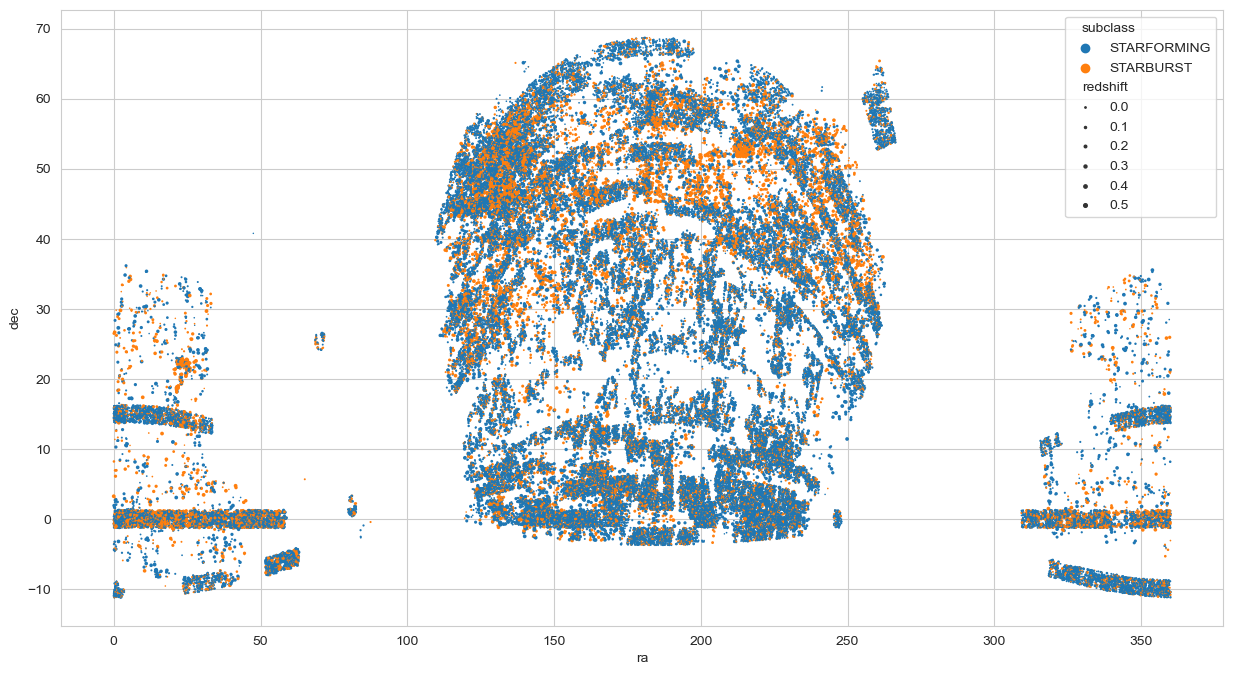

In [7]:
# make a scatterplot using the ra/dec data with subclass and redshift
plt.figure(figsize=(15, 8))
sns.scatterplot(x='ra', y='dec',
                hue='subclass', size='redshift',
                sizes=(1, 8), linewidth=0,
                data=data);

In [8]:
# drop some of the rows we are not going to use - ids and location data
data.drop(columns=['objid', 'specobjid', 'ra', 'dec', 'class'], inplace=True)

In [9]:
# oridinal encoding - replace subclass with a 0/1 for classification
data['subclass'].replace(['STARFORMING', 'STARBURST'],[0,1], inplace=True)

In [11]:
# Perform one-way MANOVA
manova = MANOVA.from_formula('u + g + r + i + z + modelFlux_u + modelFlux_g + modelFlux_r + modelFlux_i +modelFlux_z + petroRad_u + petroRad_g + petroRad_i + petroRad_r + petroRad_z + petroFlux_u + petroFlux_g + petroFlux_i + petroFlux_r + petroFlux_z + petroR50_u + petroR50_g + petroR50_i + petroR50_r + petroR50_z + psfMag_u + psfMag_r + psfMag_g + psfMag_i + psfMag_z + expAB_u + expAB_g + expAB_r + expAB_i + expAB_z + redshift + redshift_err ~ subclass', data=data)
print(manova.mv_test())

                       Multivariate linear model
                                                                       
-----------------------------------------------------------------------
       Intercept         Value    Num DF   Den DF     F Value    Pr > F
-----------------------------------------------------------------------
          Wilks' lambda   0.0024 37.0000 99962.0000 1139052.5818 0.0000
         Pillai's trace   0.9976 37.0000 99962.0000 1139052.5818 0.0000
 Hotelling-Lawley trace 421.6097 37.0000 99962.0000 1139052.5818 0.0000
    Roy's greatest root 421.6097 37.0000 99962.0000 1139052.5818 0.0000
-----------------------------------------------------------------------
                                                                       
------------------------------------------------------------------------
         subclass         Value    Num DF    Den DF     F Value   Pr > F
------------------------------------------------------------------------
           W

# Significant statistical differences
The above variables were tested using a one-way MANOVA test. A large f-value (1139052.5818) and a p-value of 0.0000 were found. This indicates there are significant statistical differences to reject the null hypothesis that the variable “subclass” is not affected by the by the independent variables.

In [12]:
data.describe()

,u,g,r,i,z,modelFlux_u,modelFlux_g,modelFlux_r,modelFlux_i,modelFlux_z,...,psfMag_i,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,subclass,redshift,redshift_err
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,18.518622,17.258221,16.821739,16.362611,15.850865,30.683321,98.845058,175.621855,244.728134,307.474895,...,18.020203,17.435735,-0.603667,-0.522111,-0.309462,-0.410153,-0.740964,0.250070,0.116753,0.000179
std,105.082004,105.069066,95.035474,100.171155,114.206165,76.552859,229.479215,435.852215,619.825871,809.166087,...,100.181687,114.218604,104.870665,104.871474,94.860919,99.991654,114.005927,0.433055,0.100169,0.052189
min,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-47.451720,-11.935840,-42.440640,-54.385510,-144.460200,...,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,0.000000,-0.000833,0.000002
25%,18.762215,17.505868,16.898845,16.527097,16.281327,9.288132,34.462902,67.453910,91.777325,104.256550,...,18.295627,17.991602,0.299999,0.398705,0.418789,0.418656,0.381288,0.000000,0.055836,0.000008
50%,19.349715,18.072640,17.459080,17.091385,16.861105,18.195690,59.005915,103.828850,145.664550,180.086150,...,18.845780,18.563315,0.508688,0.588335,0.604795,0.604254,0.575397,0.000000,0.085850,0.000011
75%,20.079470,18.656182,17.926918,17.592650,17.453848,31.259628,99.438015,173.929225,244.944825,307.044675,...,19.586577,19.299430,0.699907,0.768804,0.773924,0.773119,0.752311,1.000000,0.135148,0.000015
max,30.960000,30.420980,31.173560,30.562360,28.553240,7915.306000,18668.400000,31755.990000,51923.480000,79058.460000,...,25.966680,27.043280,1.000000,1.000000,0.999999,1.000000,0.999998,1.000000,0.572899,16.503710


In [13]:
# Check the number of outliers by z-score
numeric_cols = data.columns

for col in numeric_cols:
    print('Outliers in column: ', col)
    counter = 0
    for item in stats.zscore(data.loc[::, col]):
        if (item > 3) or (item < -3):
            counter += 1
    print("total outliers: ", counter)

# Replace outliers with mean
for col in numeric_cols:
    z_score = stats.zscore(data[col])
    # make an index of vars outside 3 and -3
    outlier_index = (z_score > 3) | (z_score < -3)
    # calculate mean without the outliers
    mean_without_outliers = data.loc[~outlier_index, col].mean()
    # replace outliers with calculated mean
    data.loc[outlier_index, col] = mean_without_outliers

Outliers in column:  u
total outliers:  11
Outliers in column:  g
total outliers:  11
Outliers in column:  r
total outliers:  9
Outliers in column:  i
total outliers:  10
Outliers in column:  z
total outliers:  13
Outliers in column:  modelFlux_u
total outliers:  896
Outliers in column:  modelFlux_g
total outliers:  982
Outliers in column:  modelFlux_r
total outliers:  902
Outliers in column:  modelFlux_i
total outliers:  855
Outliers in column:  modelFlux_z
total outliers:  815
Outliers in column:  petroRad_u
total outliers:  904
Outliers in column:  petroRad_g
total outliers:  914
Outliers in column:  petroRad_i
total outliers:  1038
Outliers in column:  petroRad_r
total outliers:  1036
Outliers in column:  petroRad_z
total outliers:  1276
Outliers in column:  petroFlux_u
total outliers:  20
Outliers in column:  petroFlux_g
total outliers:  758
Outliers in column:  petroFlux_i
total outliers:  694
Outliers in column:  petroFlux_r
total outliers:  730
Outliers in column:  petroFlux_z


In [14]:
# Check for NA values
data.isna().sum()

u               0
g               0
r               0
i               0
z               0
modelFlux_u     0
modelFlux_g     0
modelFlux_r     0
modelFlux_i     0
modelFlux_z     0
petroRad_u      0
petroRad_g      0
petroRad_i      0
petroRad_r      0
petroRad_z      0
petroFlux_u     0
petroFlux_g     0
petroFlux_i     0
petroFlux_r     0
petroFlux_z     0
petroR50_u      0
petroR50_g      0
petroR50_i      0
petroR50_r      0
petroR50_z      0
psfMag_u        0
psfMag_r        0
psfMag_g        0
psfMag_i        0
psfMag_z        0
expAB_u         0
expAB_g         0
expAB_r         0
expAB_i         0
expAB_z         0
subclass        0
redshift        0
redshift_err    0
dtype: int64

In [15]:
# Look for duplicate values.
dup_val_result = data.duplicated().any()
print('Duplicate values results:', dup_val_result)

Duplicate values results: False


In [16]:
from sklearn.preprocessing import MinMaxScaler

# Scale the data.
scaler = MinMaxScaler()
all_cols = list(data.columns)
data_scaled = scaler.fit_transform(data.to_numpy())
data = pd.DataFrame(data=data_scaled, columns=all_cols)

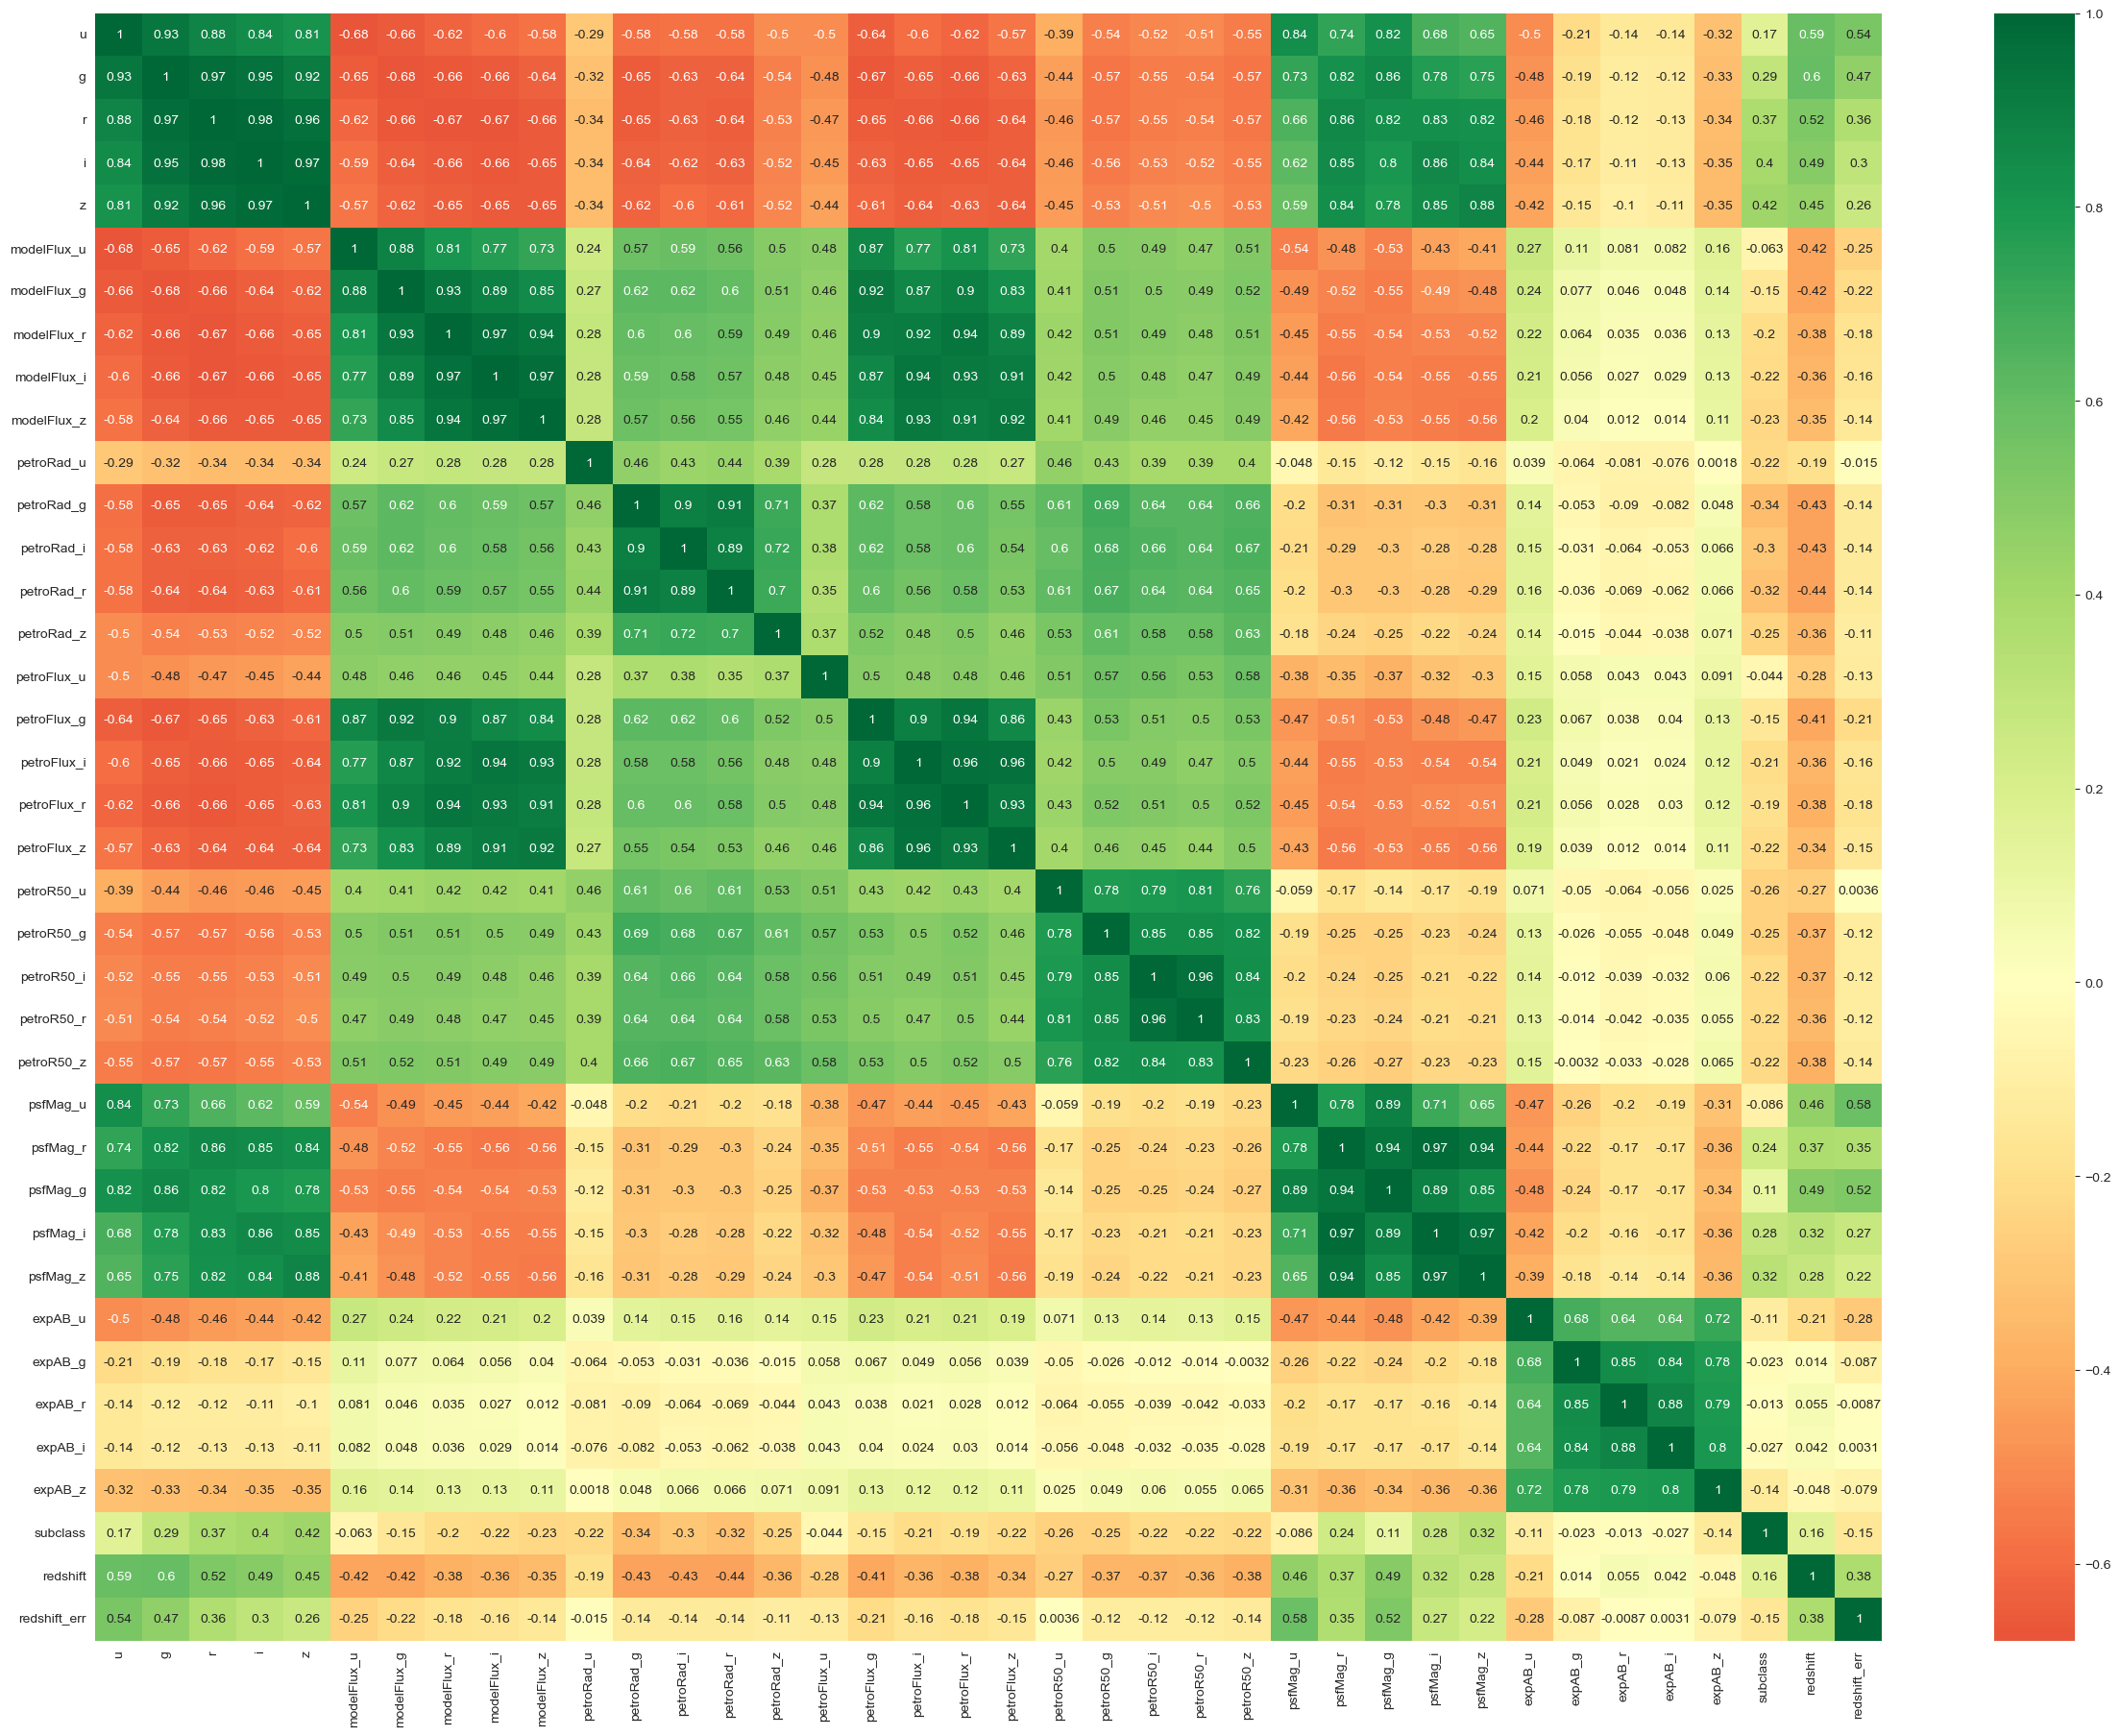

In [17]:
#Get the correlation coefficients
correlation_df = data.corr()
correlation_df
plt.figure(figsize=(30, 22))
p = sns.heatmap(data=correlation_df, annot=True, cmap='RdYlGn', center=0)

In [18]:
def drop_high_vif_columns(dataframe):
    current_cols = dataframe.columns
    # use VIF to identify Multicollinearity
    dataframe = sm.add_constant(dataframe) #(Larose & Larose 2019)
    # Variance inflation factor, VIF, for one exogenous variable
    vif_series = [inf.variance_inflation_factor(dataframe.values, i) for i in range(data.shape[1])]
    columns_to_drop = []
    for index_num in range(0, len(vif_series)):
        if vif_series[index_num] > 5:
            print(current_cols[index_num], 'has a high VIF', vif_series[index_num])
            columns_to_drop.append(current_cols[index_num])
    dataframe.drop(columns=columns_to_drop, inplace=True)
    return dataframe

In [19]:
# Save a copy of the cleaned data
data.to_csv('cleaned_data.csv')

# visualizations:

u


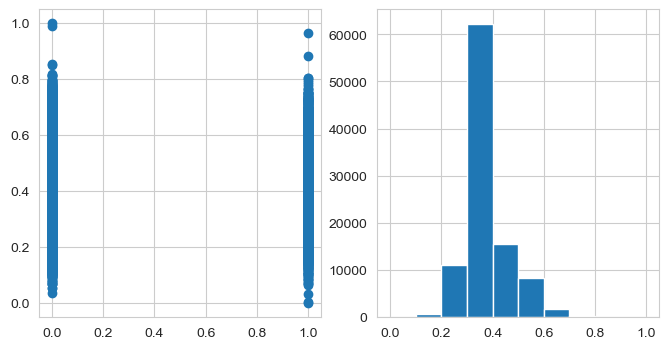

g


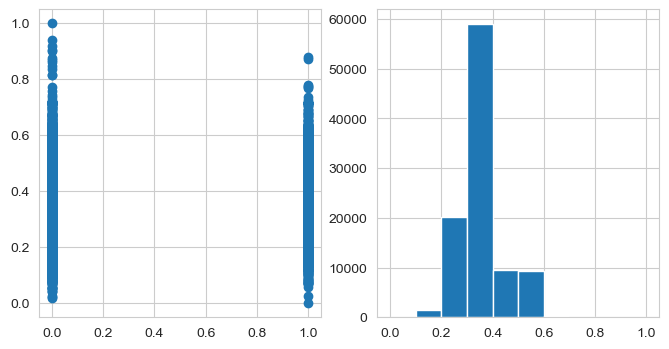

r


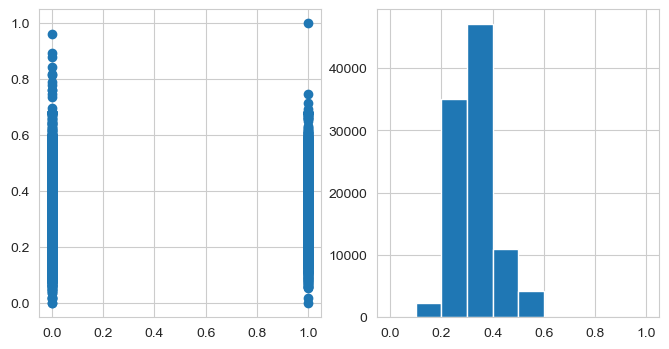

i


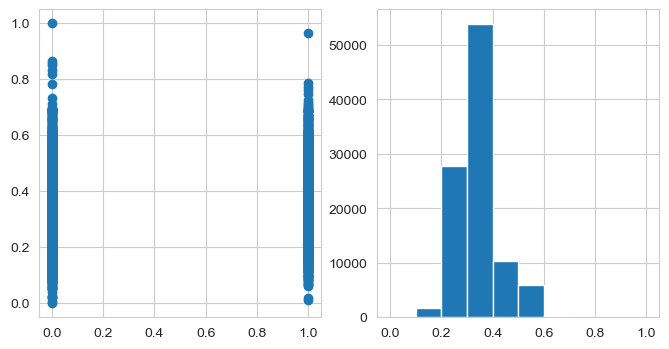

z


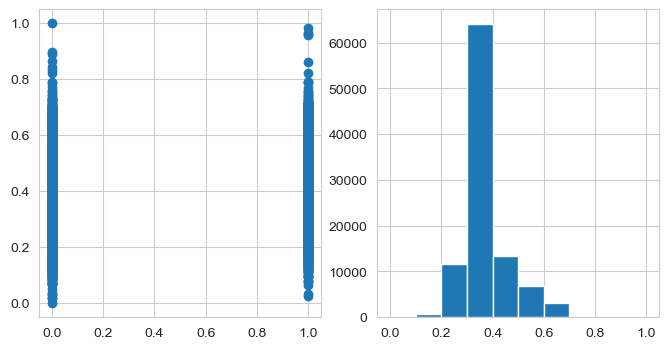

modelFlux_u


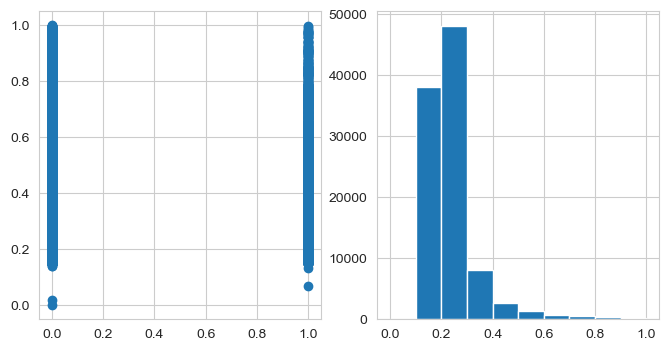

modelFlux_g


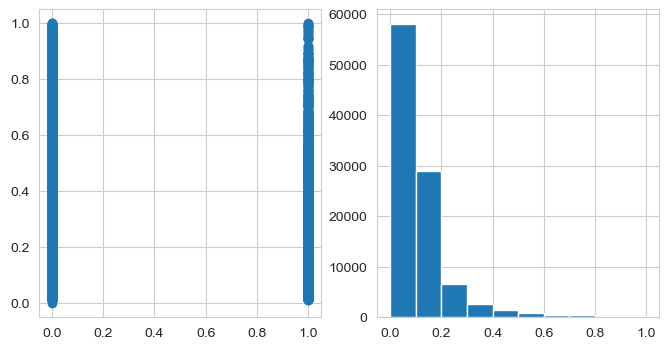

modelFlux_r


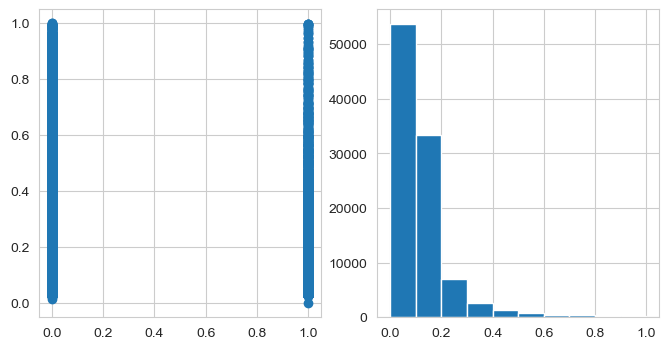

modelFlux_i


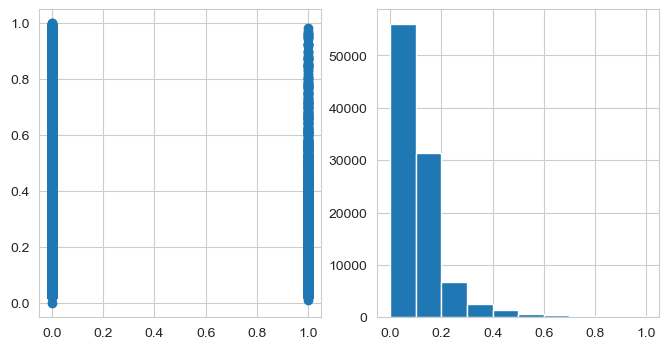

modelFlux_z


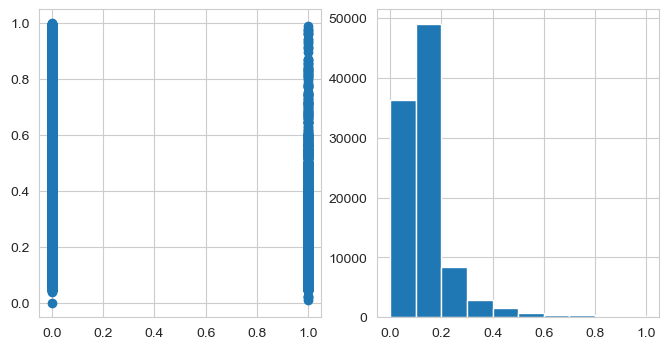

petroRad_u


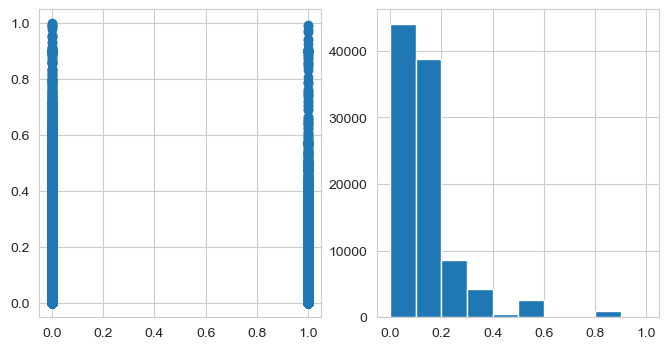

petroRad_g


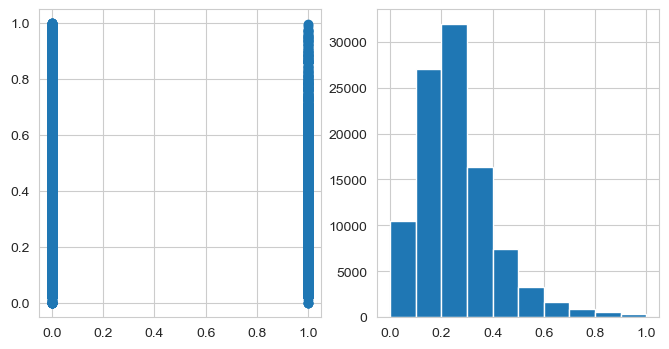

petroRad_i


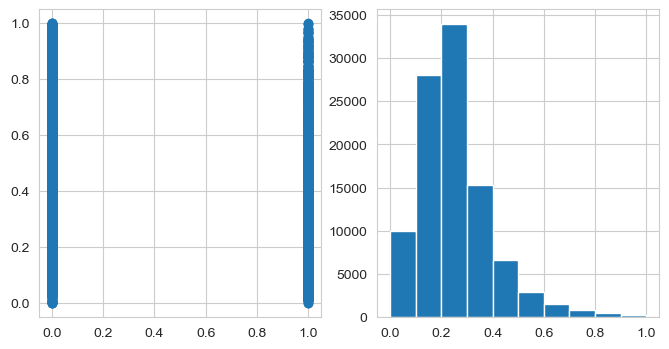

petroRad_r


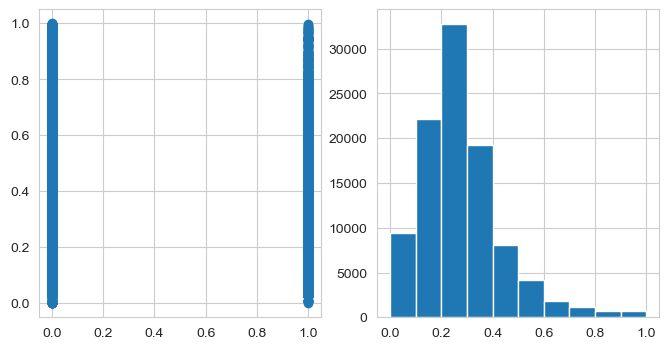

petroRad_z


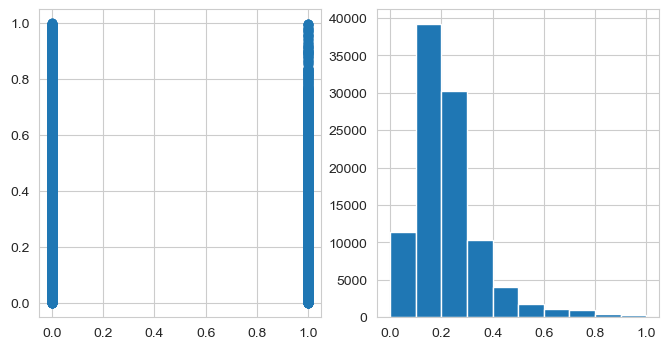

petroFlux_u


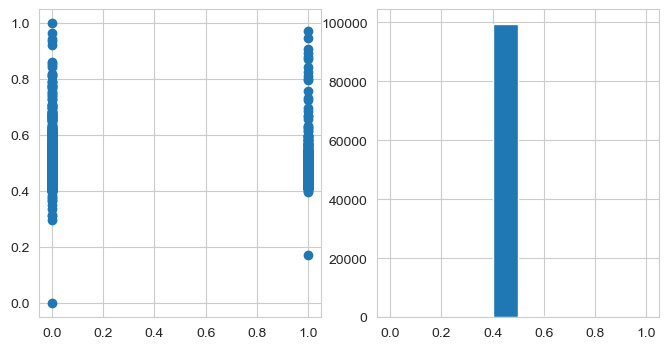

petroFlux_g


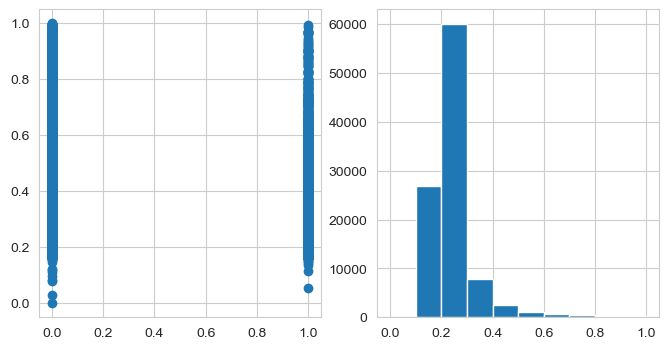

petroFlux_i


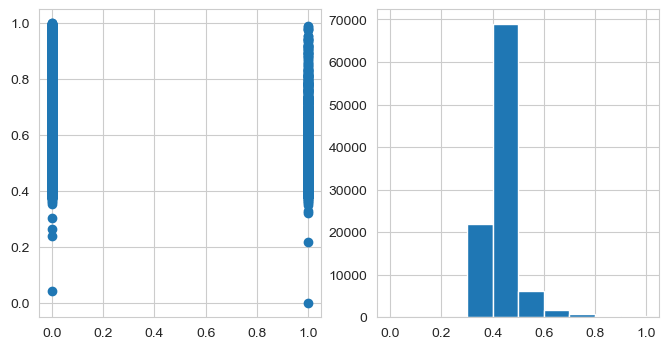

petroFlux_r


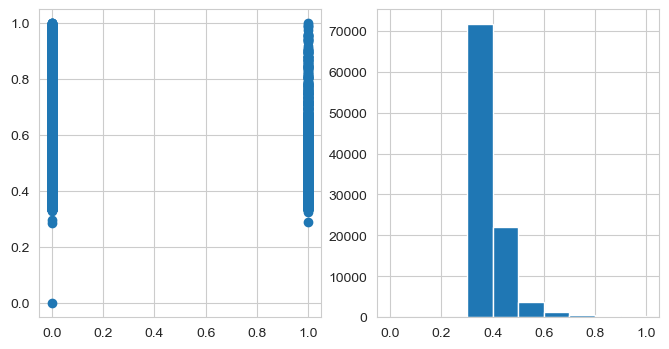

petroFlux_z


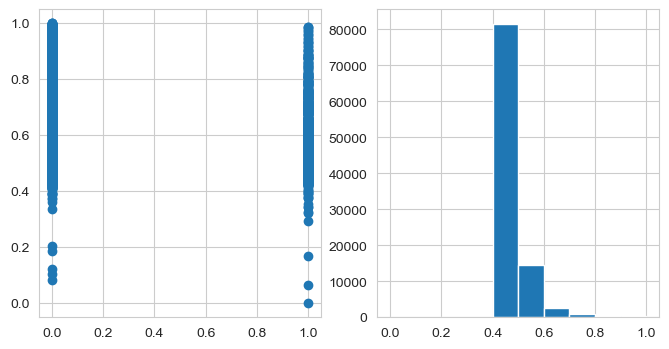

petroR50_u


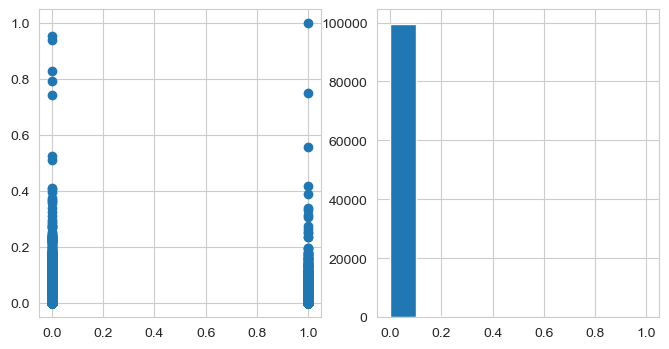

petroR50_g


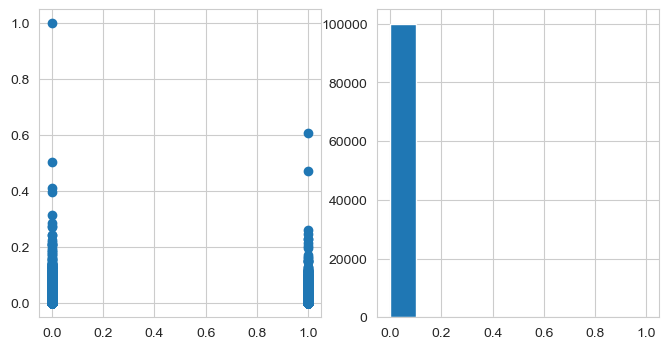

petroR50_i


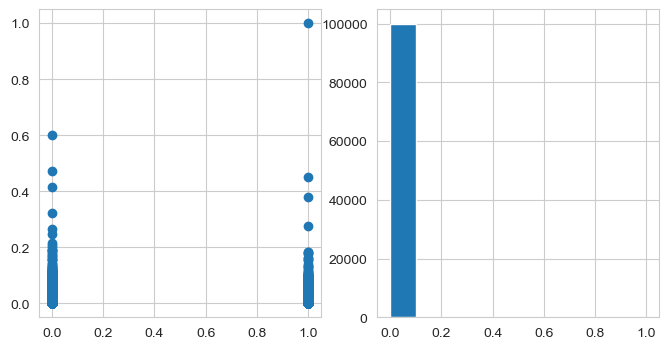

petroR50_r


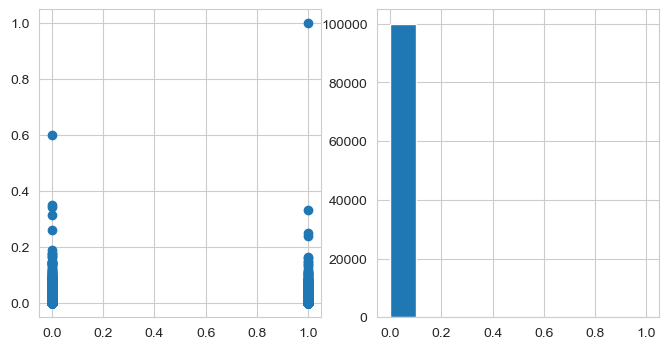

petroR50_z


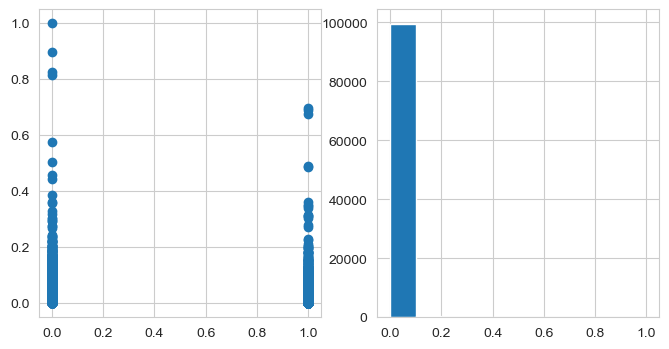

psfMag_u


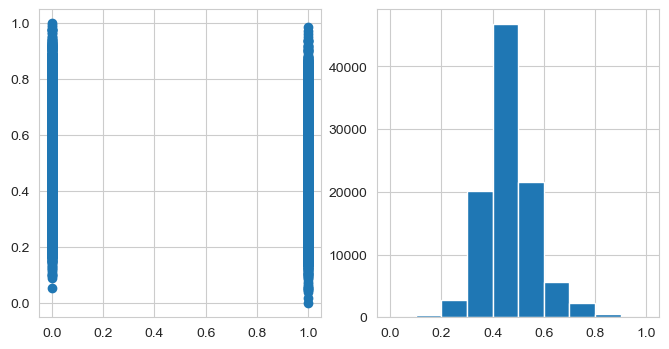

psfMag_r


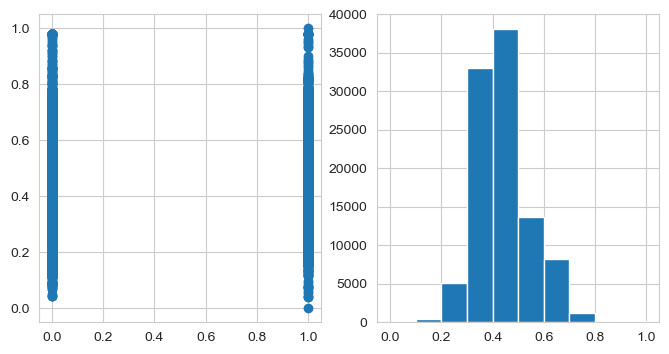

psfMag_g


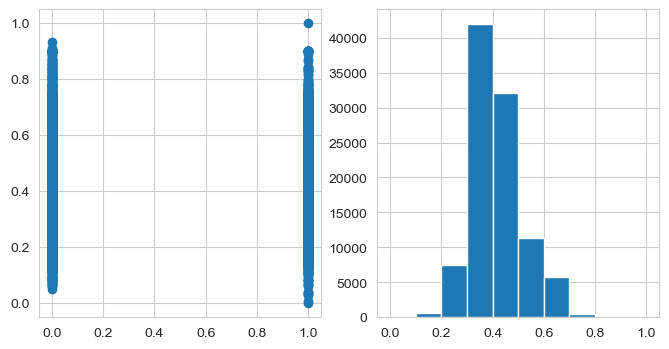

psfMag_i


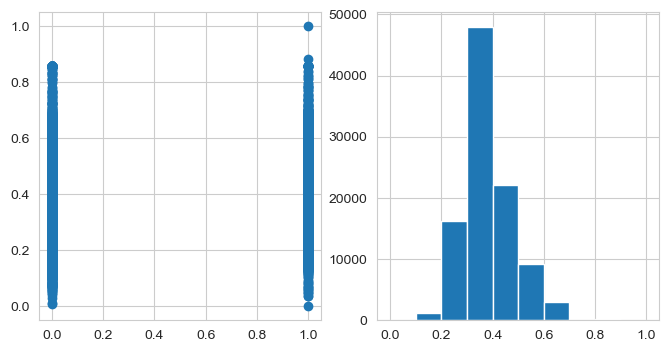

psfMag_z


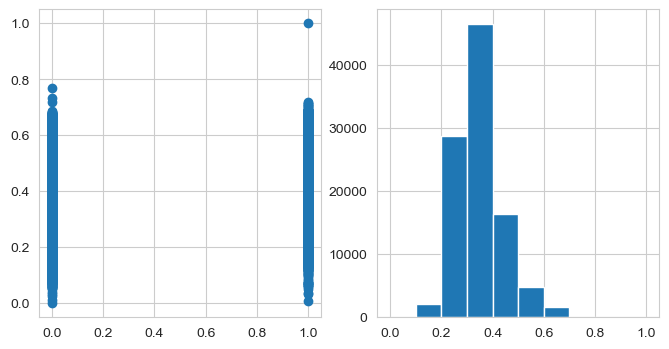

expAB_u


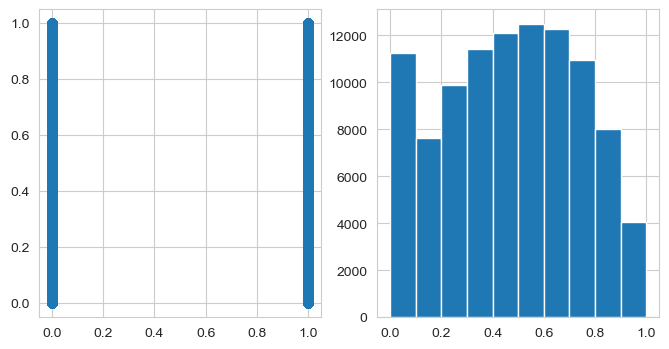

expAB_g


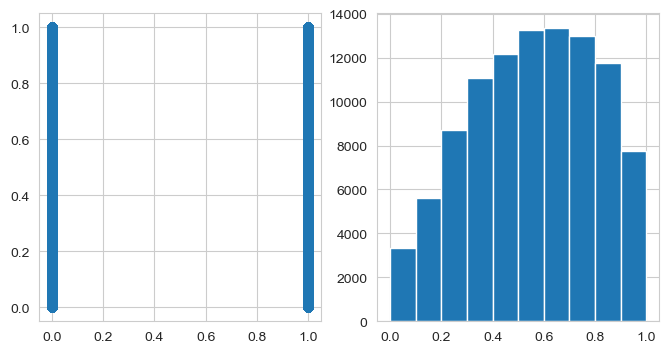

expAB_r


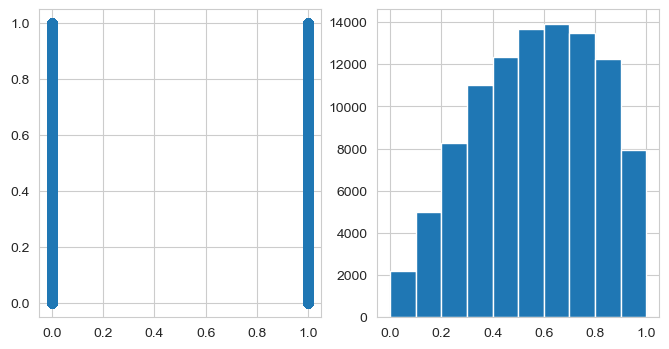

expAB_i


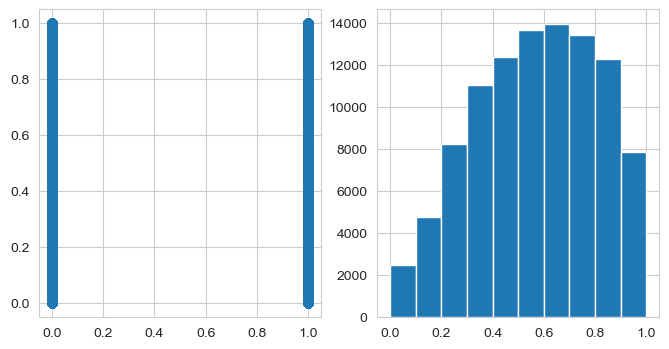

expAB_z


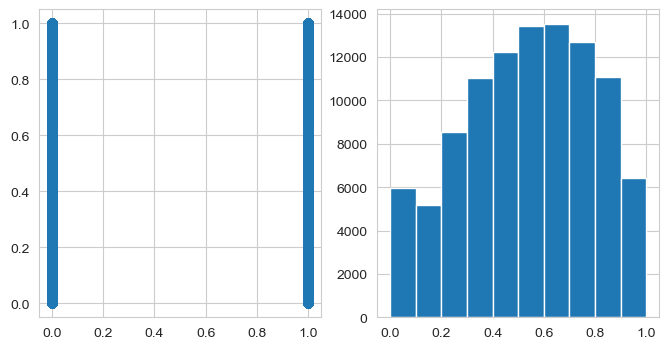

subclass


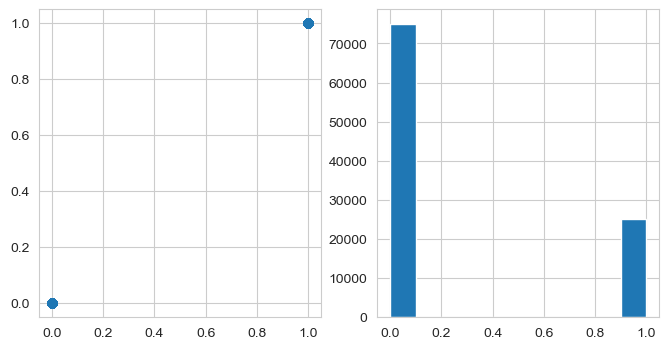

redshift


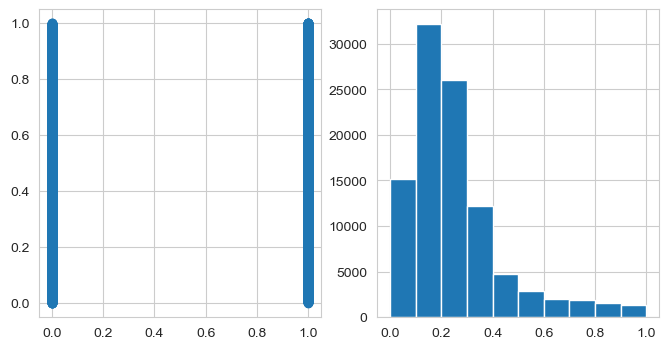

redshift_err


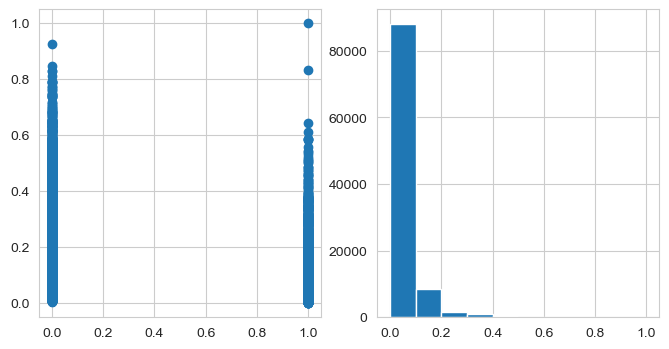

In [20]:
numeric_cols = data.columns

# make a graph of all numeric columns
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    print(col)
    plt.subplot(1, 2, 1)
    # box plot
    plt.scatter(data=data, x='subclass', y=col)
    plt.subplot(1, 2, 2)
    # histogram
    plt.hist(data[col])
    plt.show()

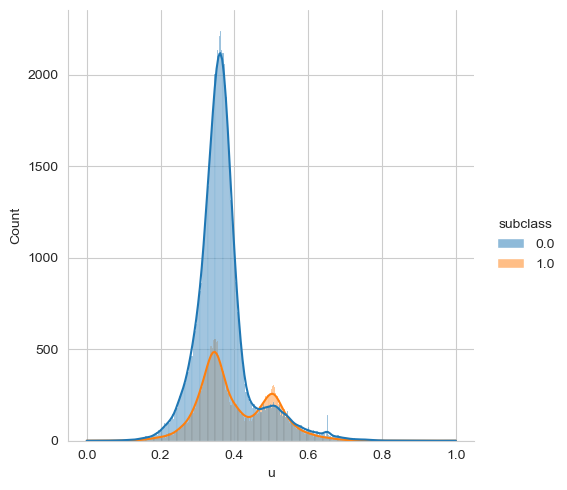

In [21]:
sns.displot(data=data, x='u', hue='subclass', kde=True);

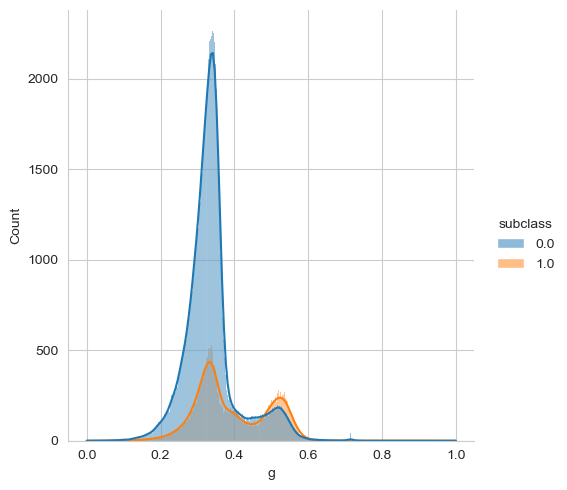

In [22]:
sns.displot(data=data, x='g', hue='subclass', kde=True);

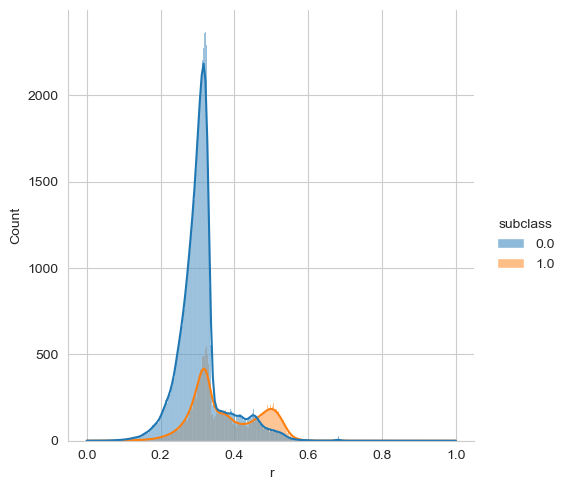

In [23]:
sns.displot(data=data, x='r', hue='subclass', kde=True);

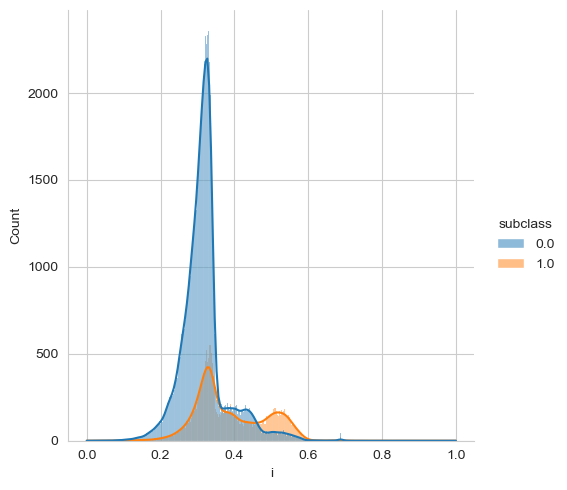

In [24]:
sns.displot(data=data, x='i', hue='subclass', kde=True);

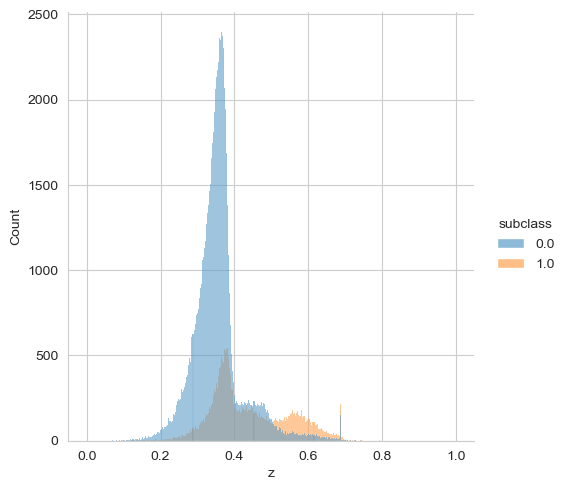

In [25]:
sns.displot(data=data, x='z', hue='subclass');

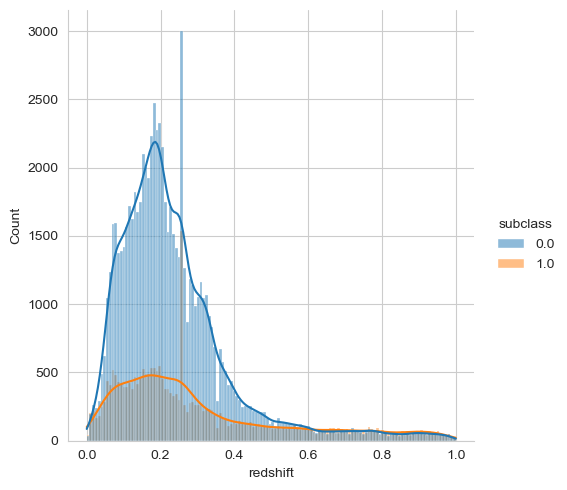

In [26]:
sns.displot(data=data, x='redshift', hue='subclass', kde=True);

/Users/bryancimo/mambaforge/envs/workspace/lib/python3.10/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


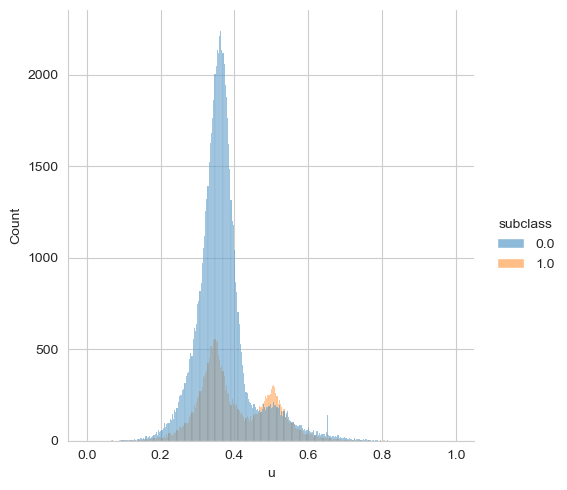

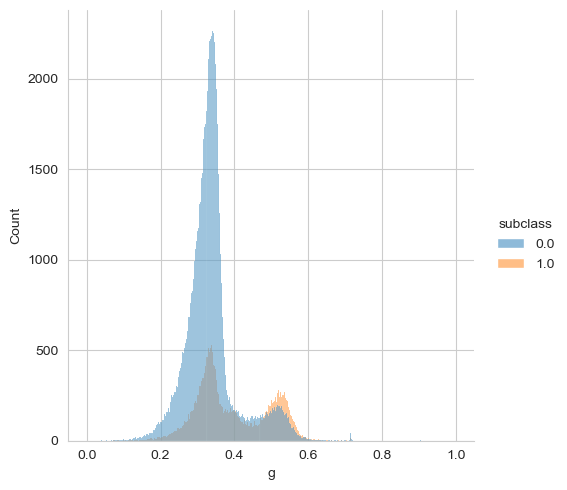

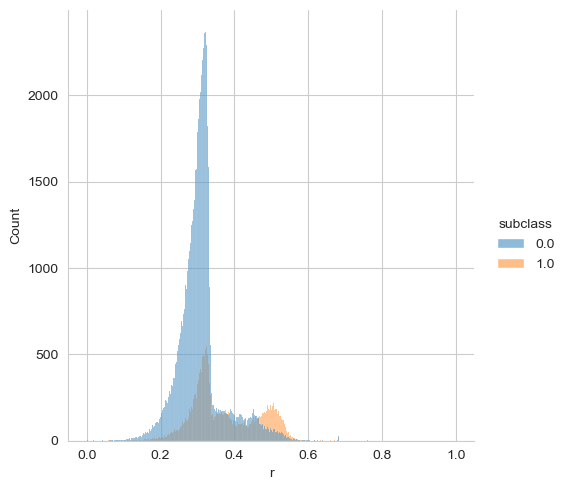

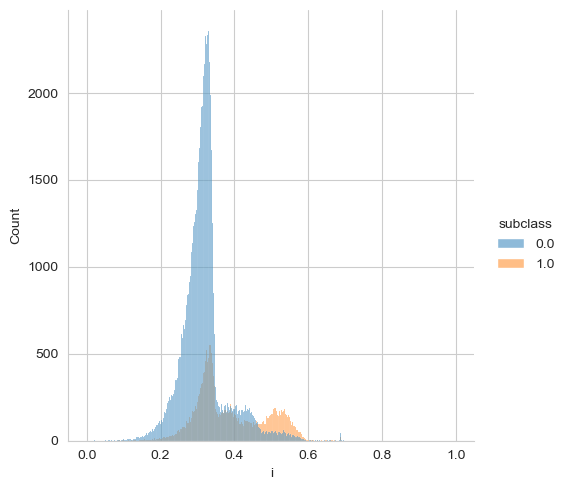

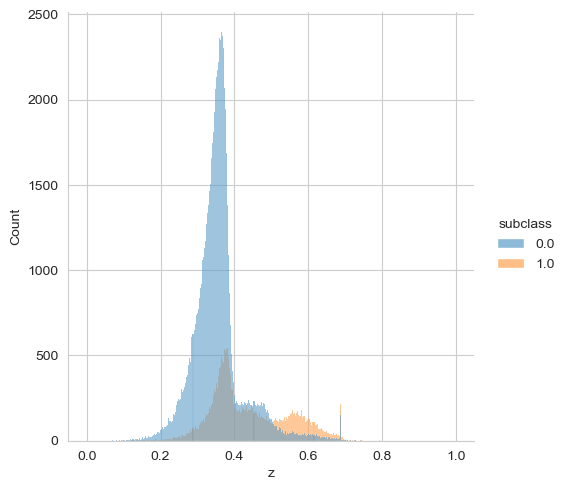

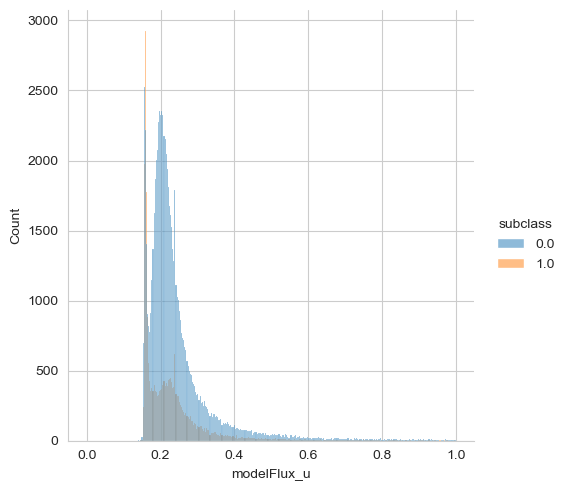

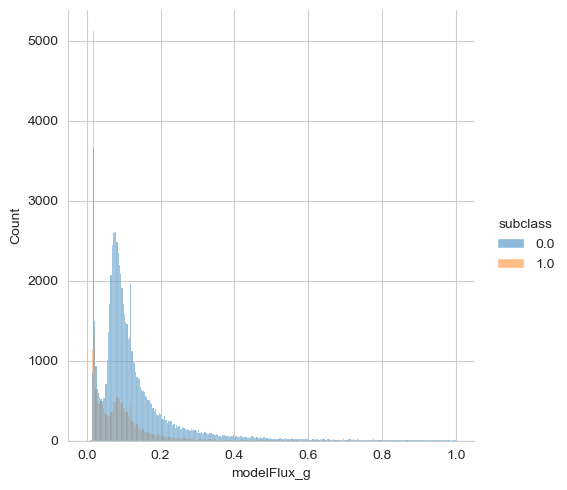

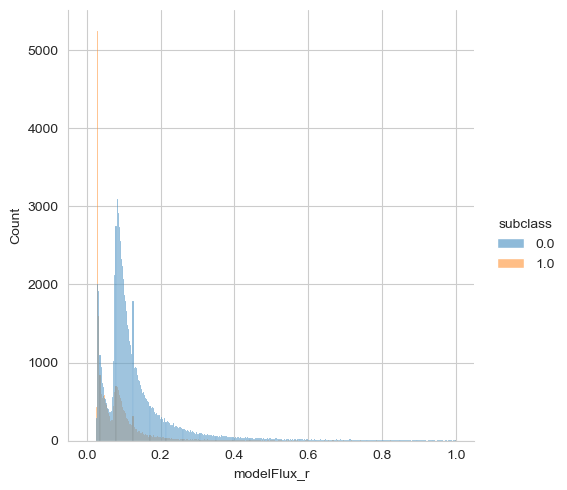

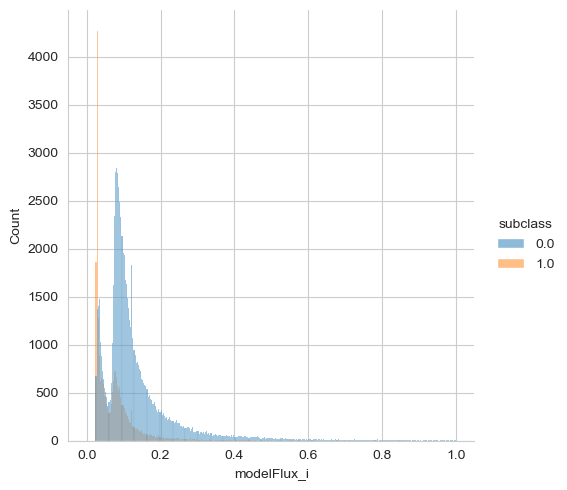

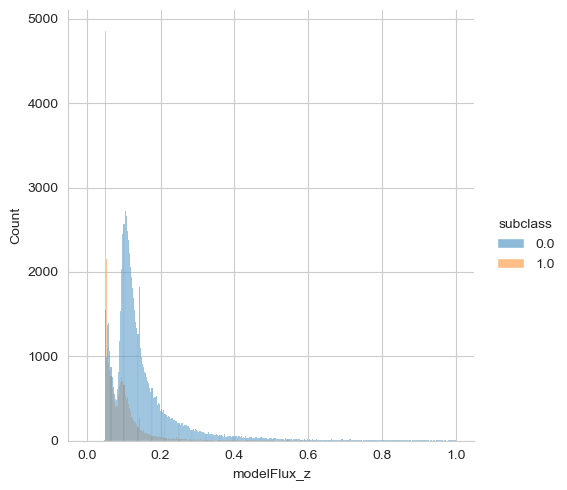

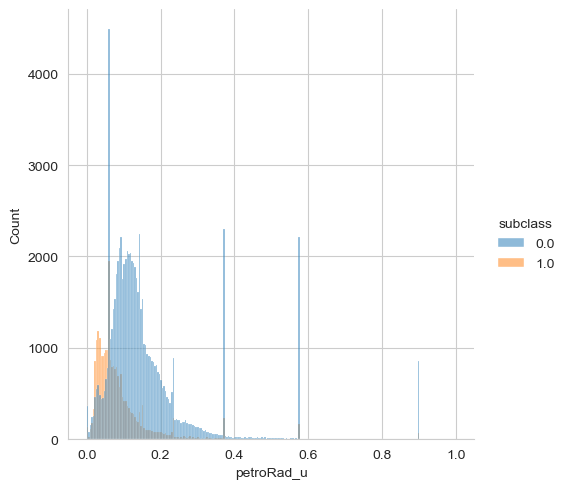

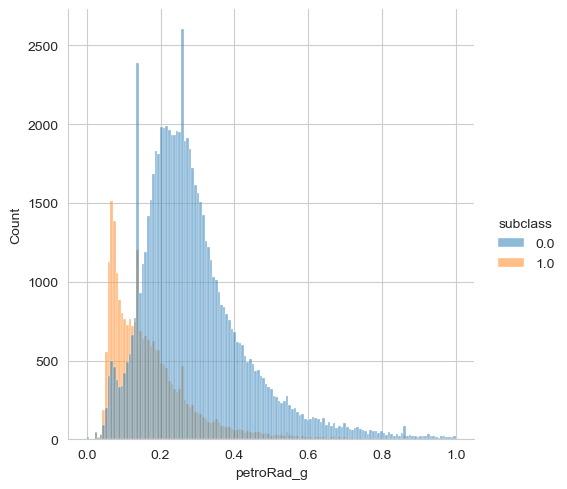

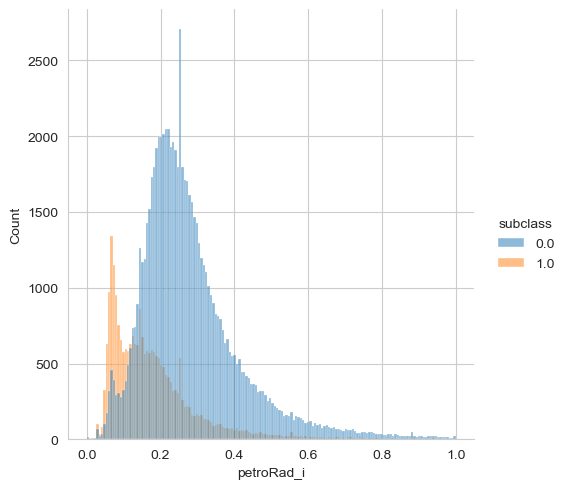

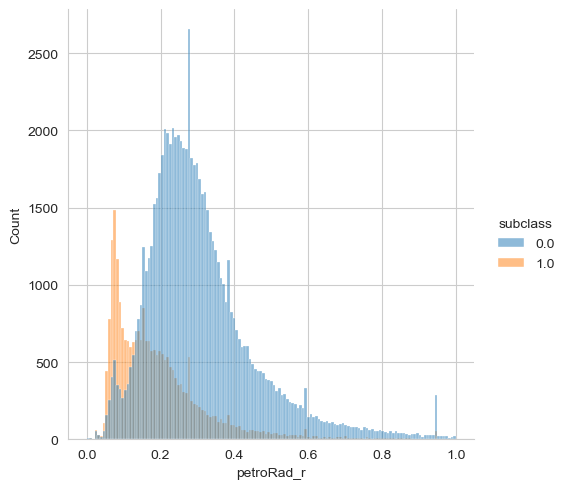

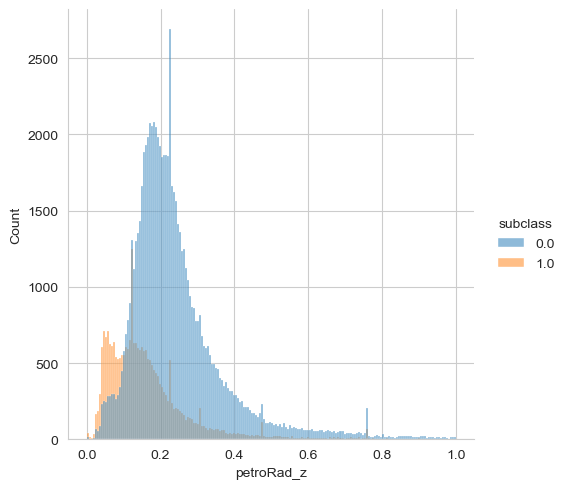

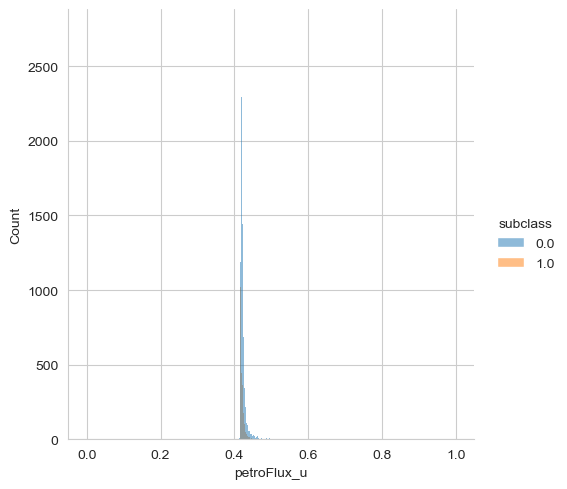

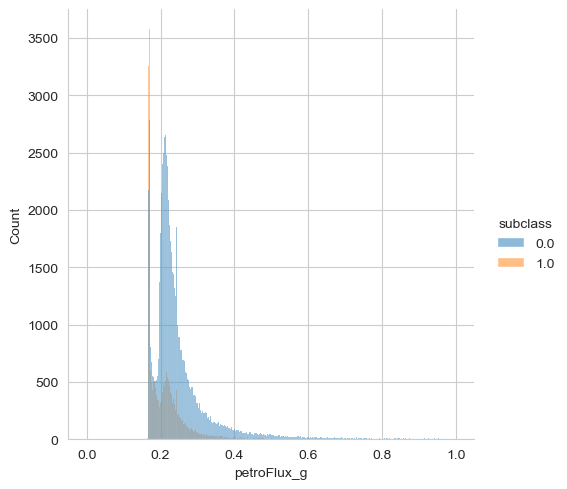

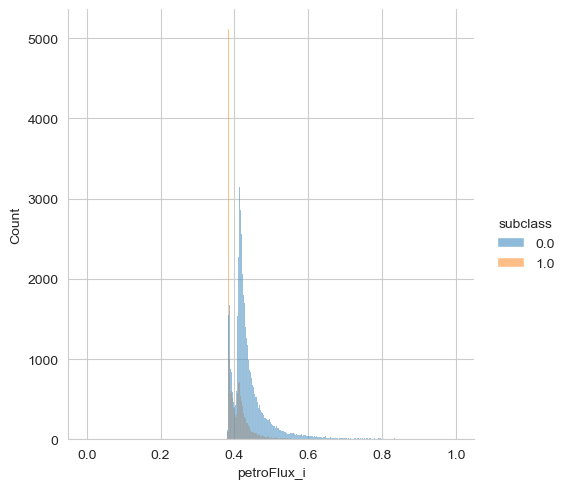

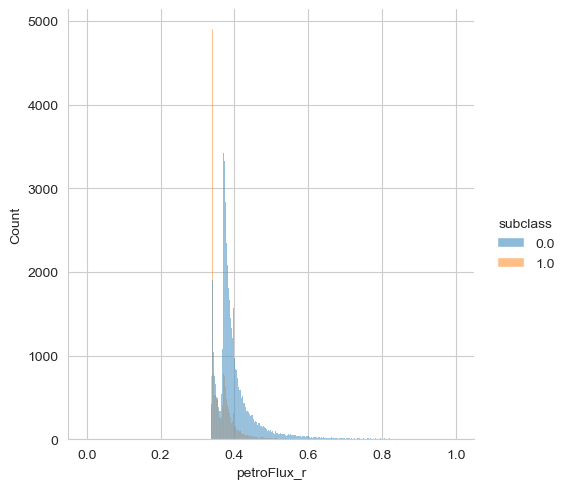

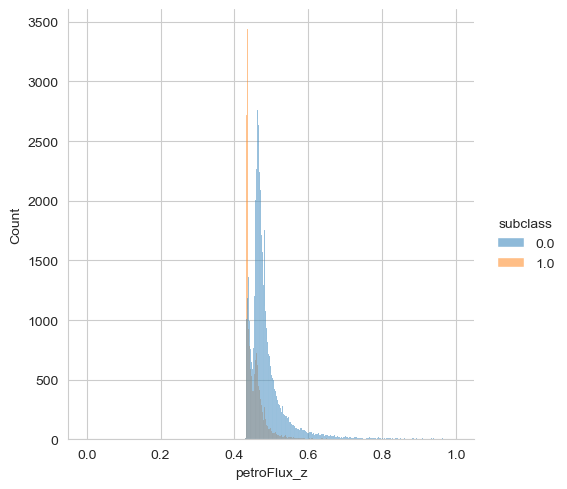

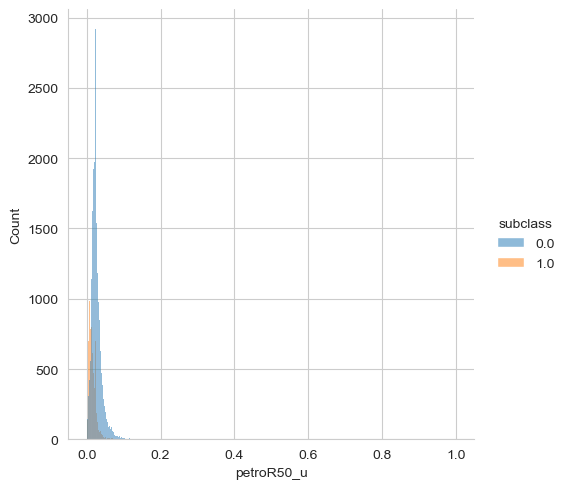

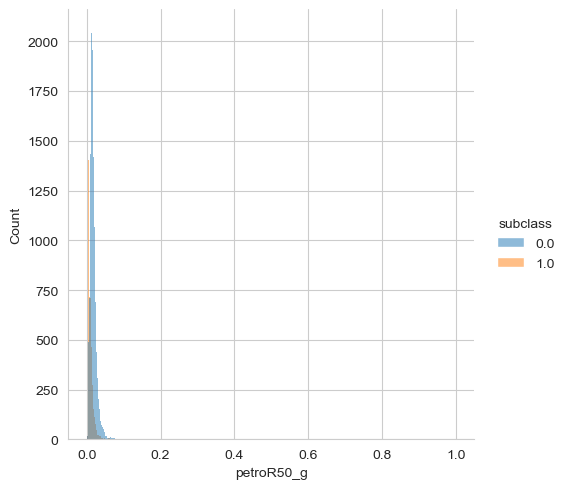

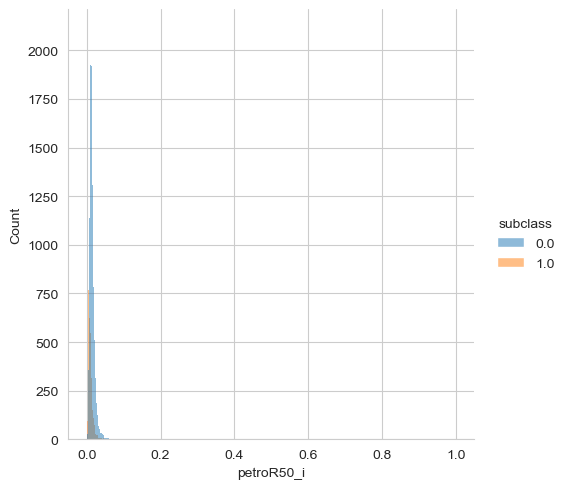

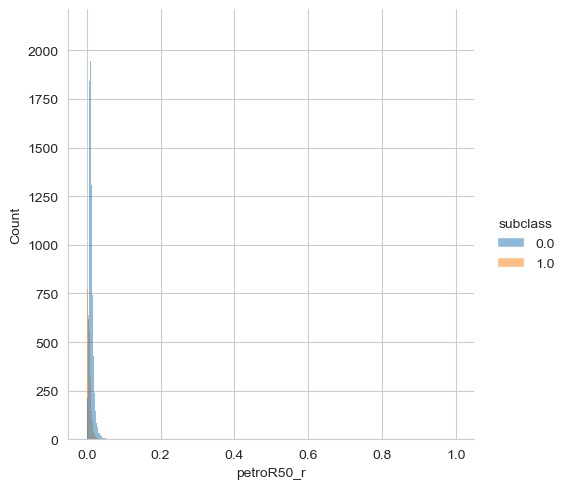

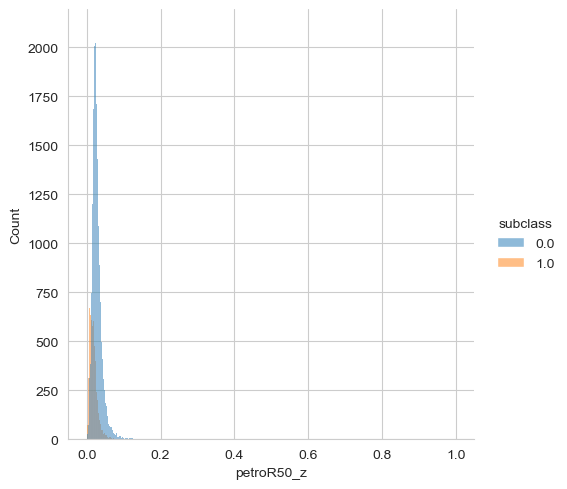

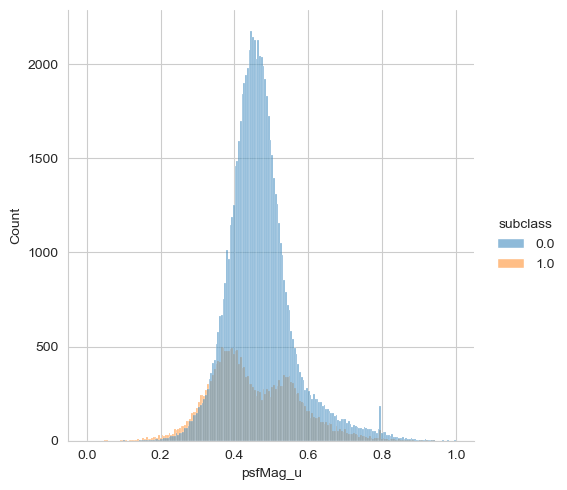

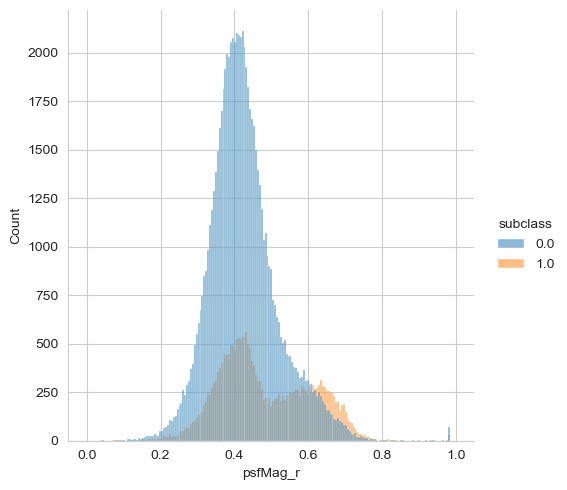

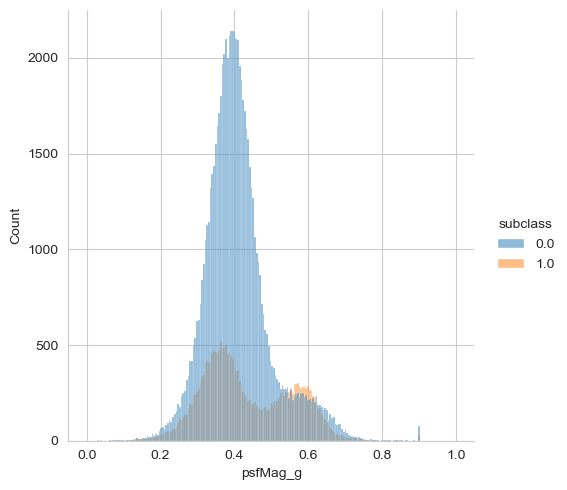

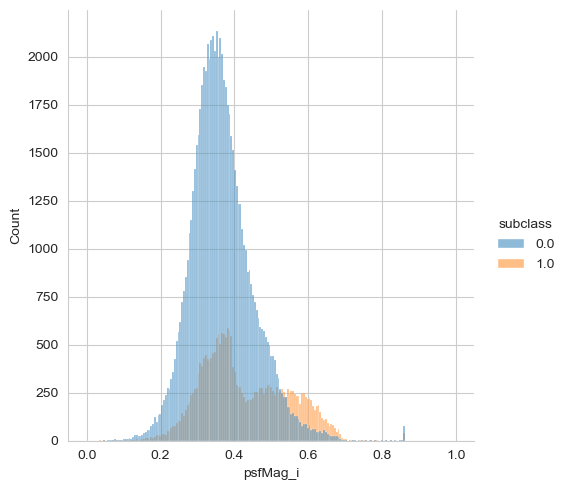

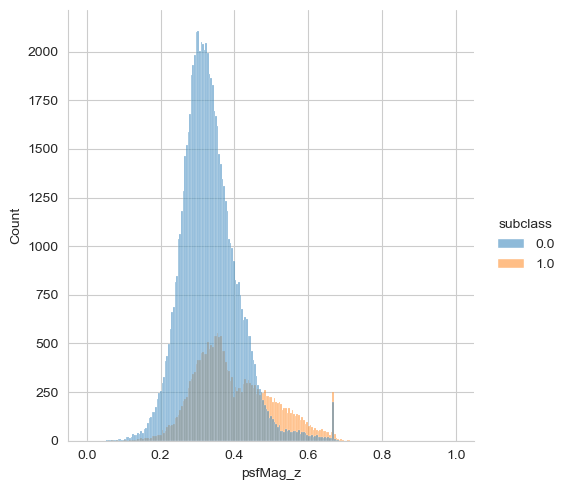

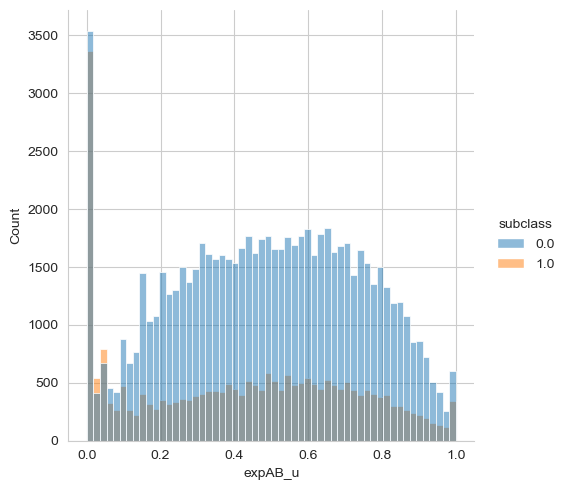

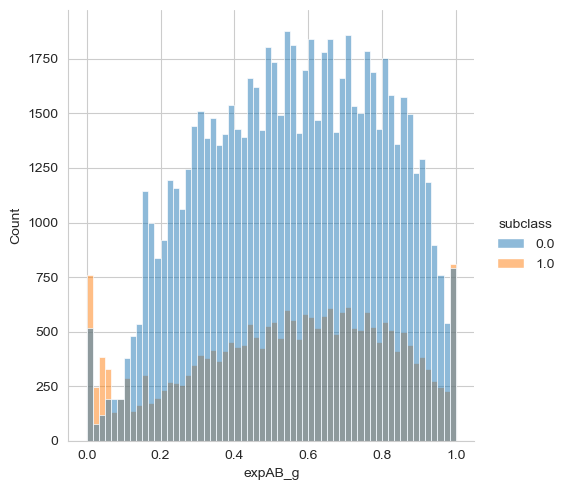

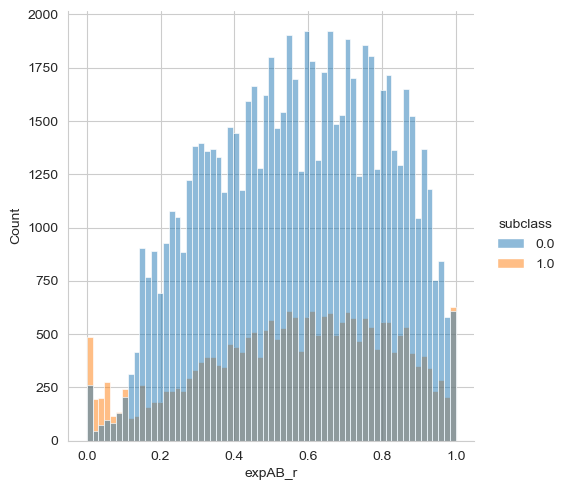

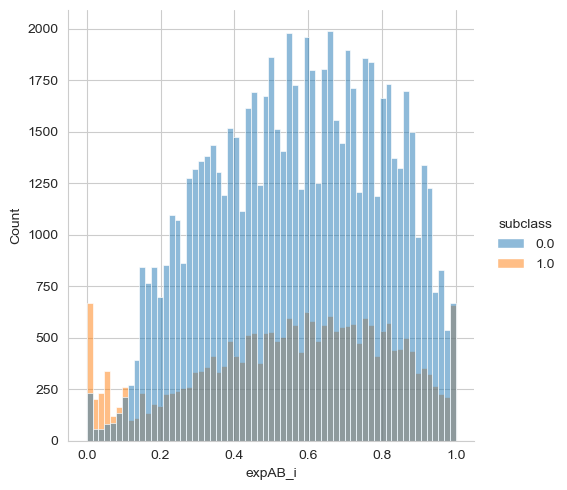

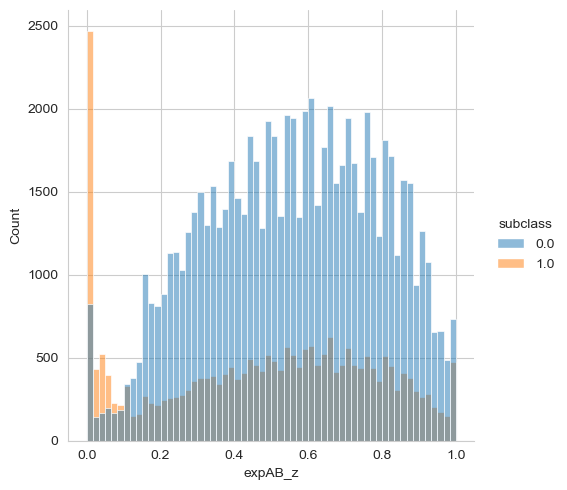

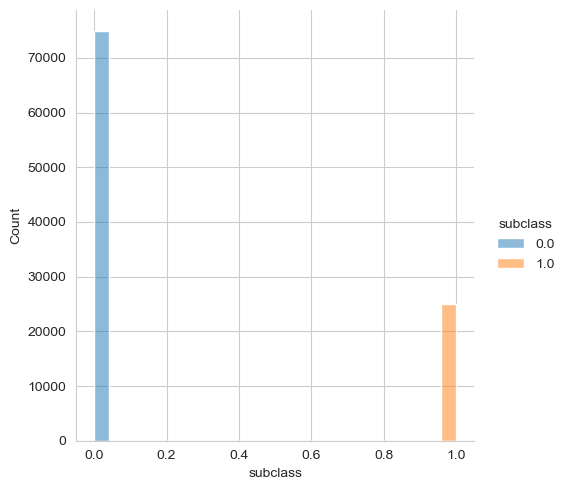

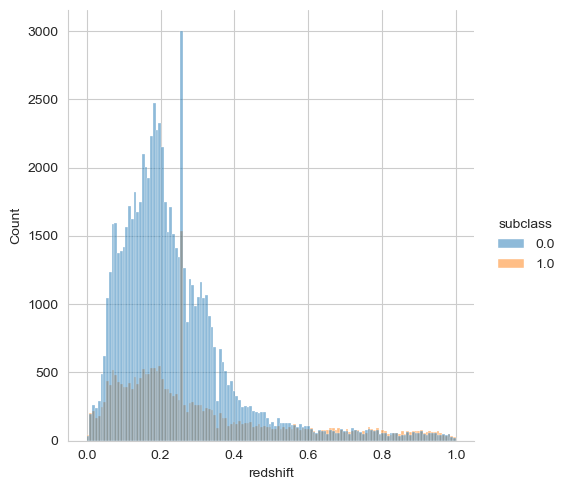

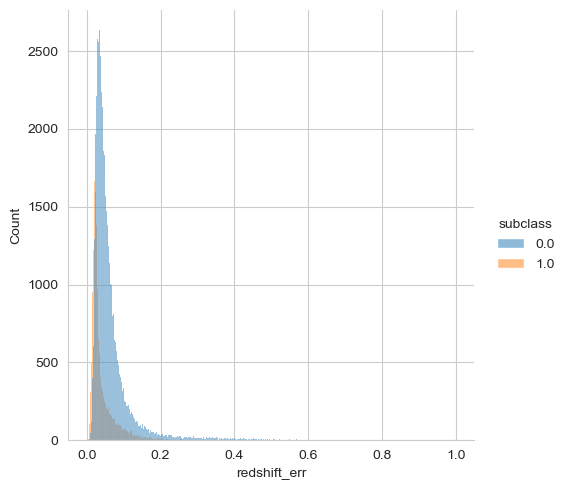

In [27]:
test_cols = ['petroFlux_u','petroFlux_g','petroFlux_i','petroFlux_r','petroFlux_z']

for col in numeric_cols:
    sns.displot(data=data, x=col, hue='subclass');

In [30]:
data.columns

Index(['u', 'g', 'r', 'i', 'z', 'modelFlux_u', 'modelFlux_g', 'modelFlux_r',
       'modelFlux_i', 'modelFlux_z', 'petroRad_u', 'petroRad_g', 'petroRad_i',
       'petroRad_r', 'petroRad_z', 'petroFlux_u', 'petroFlux_g', 'petroFlux_i',
       'petroFlux_r', 'petroFlux_z', 'petroR50_u', 'petroR50_g', 'petroR50_i',
       'petroR50_r', 'petroR50_z', 'psfMag_u', 'psfMag_r', 'psfMag_g',
       'psfMag_i', 'psfMag_z', 'expAB_u', 'expAB_g', 'expAB_r', 'expAB_i',
       'expAB_z', 'subclass', 'redshift', 'redshift_err'],
      dtype='object')

In [31]:
# Split features and target
X = data.drop('subclass', axis=1)
y = data['subclass']

In [32]:
y.value_counts()

0.0    74993
1.0    25007
Name: subclass, dtype: int64

In [33]:
# # Apply SMOTE to address class imbalance - Synthetic Minority Over-sampling Technique.
# smote = SMOTE(random_state=23)
# X_resampled, y_resampled = smote.fit_resample(X, y)

In [34]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [35]:
X_train

,u,g,r,i,z,modelFlux_u,modelFlux_g,modelFlux_r,modelFlux_i,modelFlux_z,...,psfMag_g,psfMag_i,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,redshift,redshift_err
64850,0.291896,0.259176,0.241642,0.249069,0.282975,0.346780,0.290829,0.274578,0.278790,0.283519,...,0.326318,0.300246,0.264789,0.368332,0.327956,0.332382,0.328735,0.332834,0.176887,0.035531
40242,0.435211,0.419014,0.384566,0.395393,0.439016,0.171609,0.032797,0.045729,0.042695,0.067035,...,0.493090,0.436574,0.396185,0.392836,0.697480,0.805052,0.762354,0.837650,0.583960,0.036546
56927,0.360775,0.342821,0.312657,0.319775,0.359902,0.214874,0.080782,0.094841,0.094836,0.114025,...,0.390590,0.352831,0.316078,0.762770,0.823851,0.820427,0.853947,0.859245,0.476250,0.043425
40137,0.365033,0.354612,0.332007,0.342421,0.386584,0.210693,0.068742,0.074808,0.071237,0.090916,...,0.441492,0.422977,0.378291,0.726526,0.853326,0.805448,0.793765,0.856950,0.370970,0.034246
49373,0.322351,0.303941,0.284121,0.294022,0.333303,0.269765,0.143090,0.140975,0.136693,0.150115,...,0.380413,0.344530,0.316826,0.765278,0.784795,0.800014,0.806819,0.768866,0.222733,0.031427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71711,0.317438,0.291225,0.280818,0.295573,0.340147,0.279688,0.174276,0.148047,0.133577,0.139233,...,0.435731,0.423270,0.390723,0.526268,0.492230,0.496238,0.473238,0.462906,0.083986,0.076099
9704,0.315023,0.312169,0.303969,0.323110,0.368386,0.284875,0.126244,0.106427,0.090718,0.105524,...,0.313977,0.351560,0.324843,0.719879,0.907190,0.949226,0.958202,0.881036,0.069799,0.013578
76726,0.337794,0.337210,0.322689,0.331523,0.380658,0.243401,0.087424,0.083571,0.081381,0.095191,...,0.302937,0.297945,0.294154,0.553702,0.782451,0.759208,0.811322,0.755851,0.170474,0.025283
92105,0.348477,0.332959,0.315702,0.327046,0.370255,0.228770,0.092898,0.091199,0.086171,0.103809,...,0.327118,0.317698,0.295662,0.499356,0.545939,0.571850,0.565055,0.587187,0.221595,0.022924


In [36]:
import tensorflow as tf

# setup for early stopping to help mitigate overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', # value to monitor
    min_delta=0.015, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True, # restore model weights from the best epoch
)

# setup the main model
model = tf.keras.Sequential([
    # embedding layer - first layer is setup for input
    layers.Dense(64, input_dim=X_train.shape[1], activation='relu'), # densely connected neural network layer
    layers.Dense(128, activation='relu'), # densely connected neural network layer
    layers.Dropout(0.3), # dropout 30% - helps with overfit
    layers.Dense(64, activation='relu'), # densely connected neural network layer
    layers.Dropout(0.3), # dropout 30% - helps with overfit
    layers.Dense(1, activation='sigmoid') # densely connected neural network layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2432      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 19,073
Trainable params: 19,073
Non-traina

In [37]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
num_epochs = 50

# fit the model
fit_model = model.fit(X_train,
                      y_train,
                      epochs=num_epochs,
                      validation_data=(X_test, y_test),
                      verbose=1,
                      callbacks=early_stopping
                      )

Epoch 1/50
2500/2500 [==============================] - 4s 1ms/step - loss: 0.3371 - accuracy: 0.8584 - val_loss: 0.2995 - val_accuracy: 0.8719
Epoch 2/50
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2937 - accuracy: 0.8763 - val_loss: 0.2815 - val_accuracy: 0.8847
Epoch 3/50
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2858 - accuracy: 0.8806 - val_loss: 0.3301 - val_accuracy: 0.8629
Epoch 4/50
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2816 - accuracy: 0.8808 - val_loss: 0.2712 - val_accuracy: 0.8878
Epoch 5/50
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2776 - accuracy: 0.8824 - val_loss: 0.2704 - val_accuracy: 0.8878
Epoch 6/50
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2723 - accuracy: 0.8845 - val_loss: 0.2818 - val_accuracy: 0.8793
Epoch 7/50
2500/2500 [==============================] - 3s 1ms/step - loss: 0.2731 - accuracy: 0.8848 - val_loss: 0.2725 - val_accuracy:

In [39]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test Accuracy:', accuracy)

625/625 [==============================] - 1s 799us/step - loss: 0.2645 - accuracy: 0.8883
Test loss: 0.26451632380485535
Test Accuracy: 0.8883000016212463


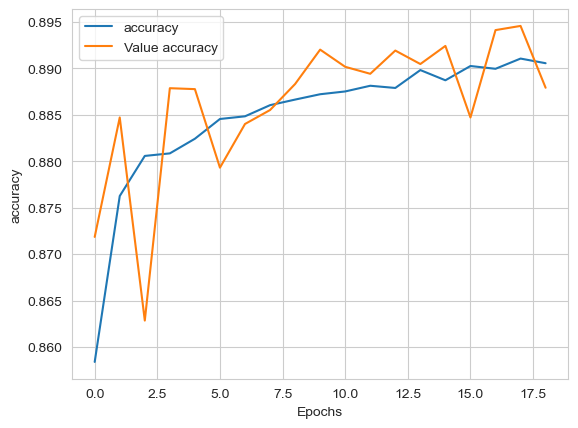

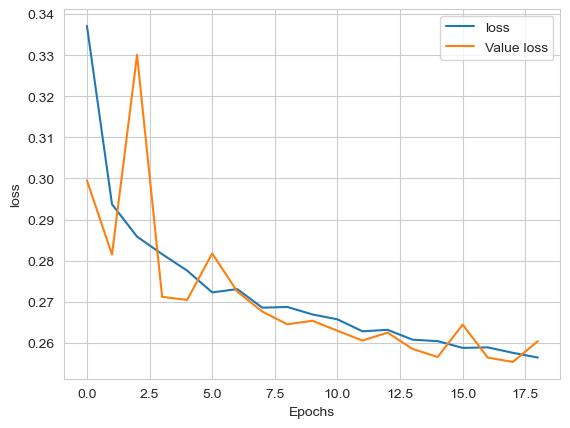

In [40]:
# plot graph
def plot_graph(model, string):
    plt.plot(model.history[string])
    plt.plot(model.history['val_' + string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'Value ' + string])
    plt.show()

# Plot the accuracy and loss
plot_graph(fit_model, 'accuracy')
plot_graph(fit_model, 'loss')

In [41]:
label_names = ['STARFORMING','STARBURST']

# Predict class labels for the test set
y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred)
# y_true = np.argmax(y_test)

y_pred_integer = np.round(y_pred).astype(int)
y_pred_integer

625/625 [==============================] - 1s 673us/step


array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [42]:
y_test

79103    0.0
3917     1.0
5290     0.0
47741    0.0
68257    1.0
        ... 
16400    0.0
91347    1.0
31000    0.0
32044    1.0
22990    0.0
Name: subclass, Length: 20000, dtype: float64

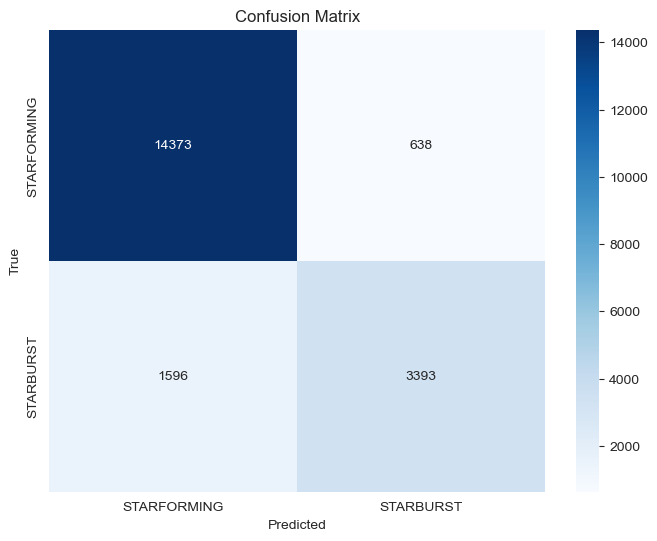

In [43]:
 # Compute confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_integer)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [44]:
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred_integer, average='weighted')
recall = recall_score(y_test, y_pred_integer, average='weighted')
f1 = f1_score(y_test, y_pred_integer, average='weighted')

print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 Score:", round(f1, 3))

Precision: 0.886
Recall: 0.888
F1 Score: 0.884


In [45]:
acc = accuracy_score(y_test, y_pred_integer)
print('Accuracy:', acc)

Accuracy: 0.8883
